# Introduction
Authors: J. Giblin-Burnham


## Flow Chart

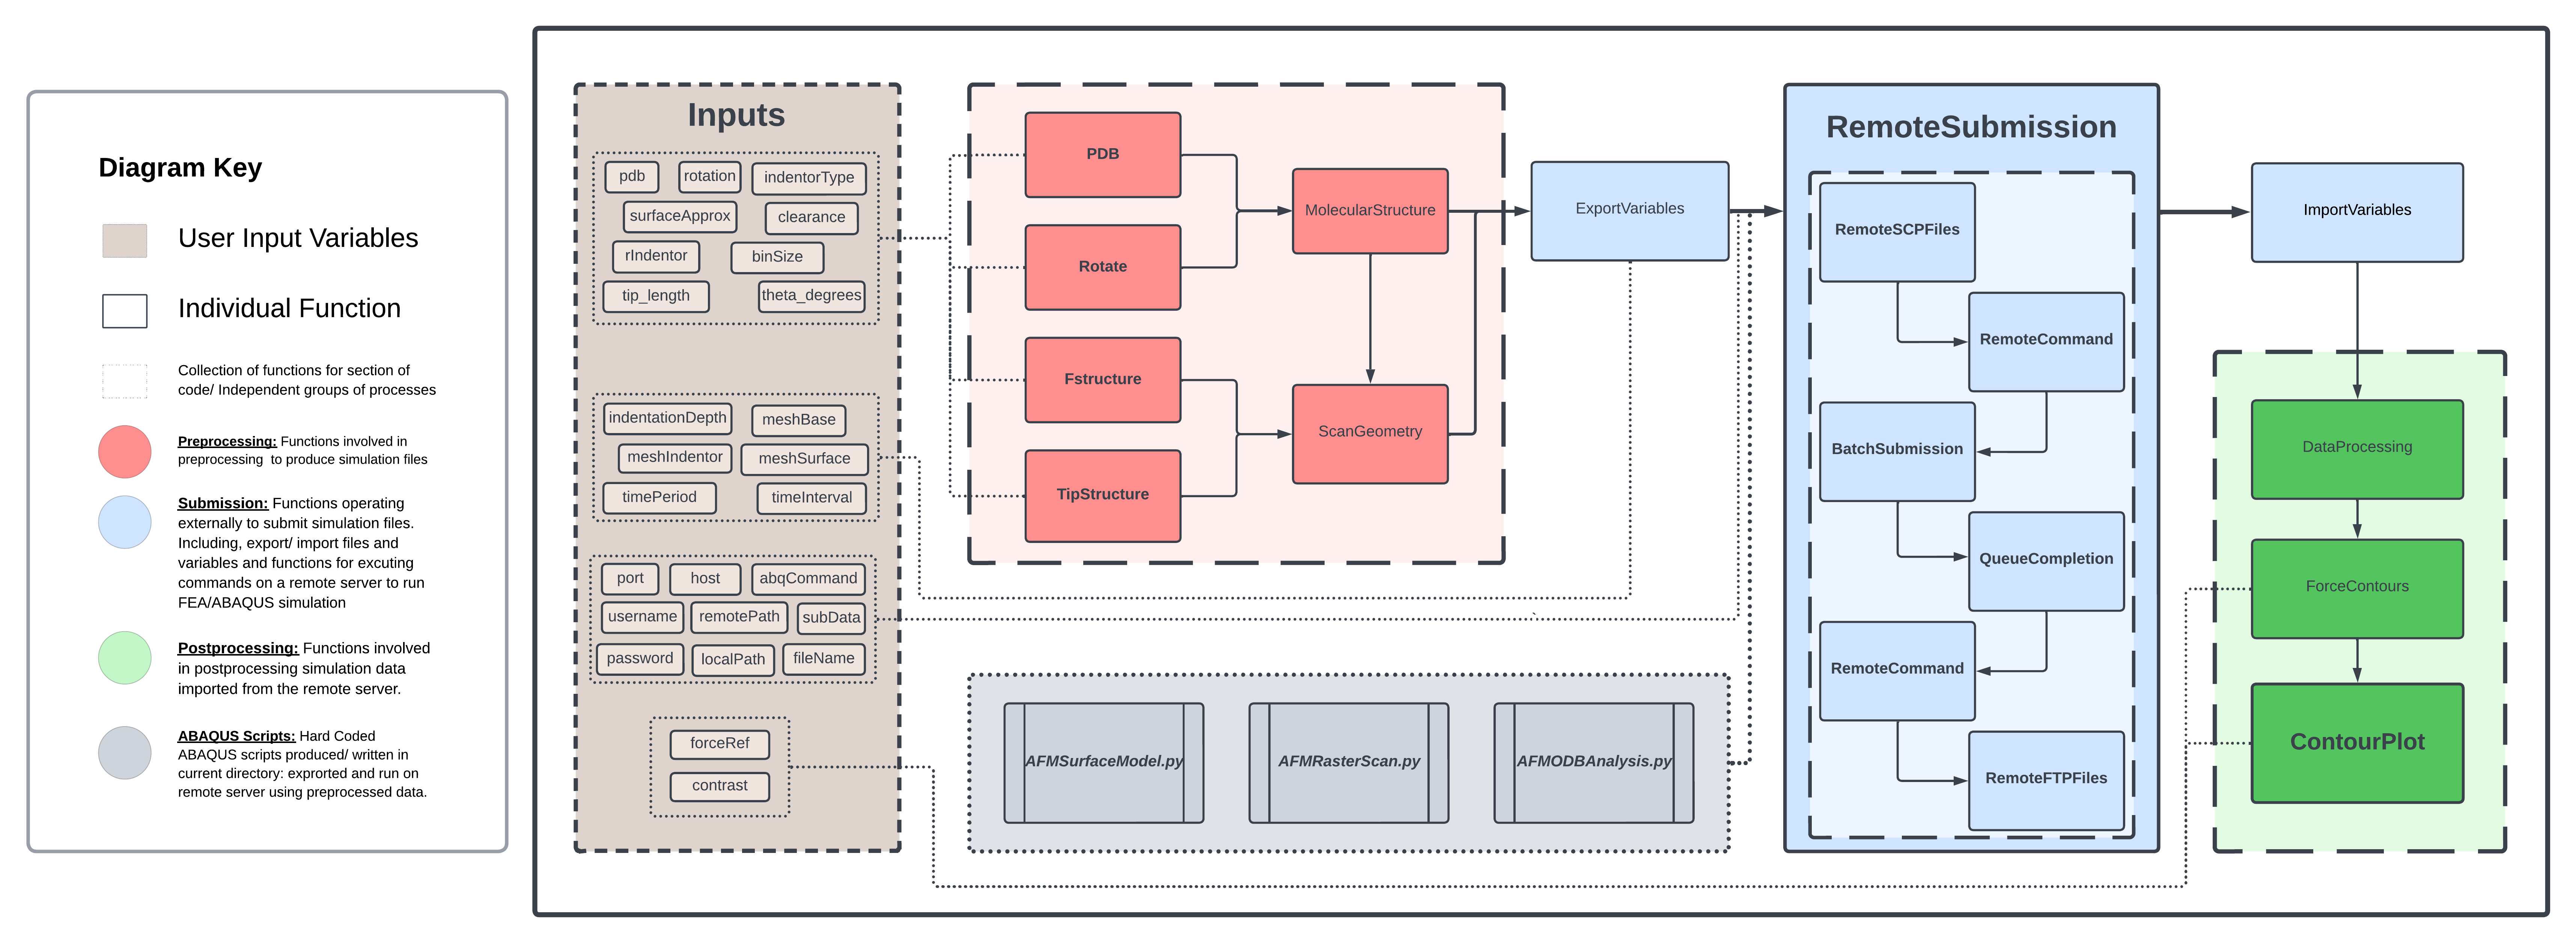

# Code Framework

## Imports

In [ ]:
# import sys
# -------------------------------------- Possible modules to pip instal-------------------------------------------------
# !{sys.executable} -m pip install py3Dmol
# !{sys.executable} -m pip install nglview
# !{sys.executable} -m pip install biopython
# !{sys.executable} -m pip install mendeleev
# !{sys.executable} -m pip install pyabaqus==2022
# !{sys.executable} -m pip install paramiko

In [32]:
# --------------------------------------------------System Imports-----------------------------------------------------
import os
import sys
import time
import subprocess
from datetime import timedelta
from platform import python_version
import paramiko

# ---------------------------------------------Mathematical/Plotting Imports--------------------------------------------
# Importing relevant maths and graphing modules
import numpy as np 
import math
from numpy import random   
from random import randrange

# Plotting import and settinngs
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

linewidth = 5.92765763889 # inch
plt.rcParams["figure.figsize"] = (1.61*linewidth, linewidth)
plt.rcParams['figure.dpi'] = 256
plt.rcParams['font.size'] = 16
plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# For displaying images in Markdown
from IPython.display import Image 

# -----------------------------------------------Specific Imports-------------------------------------------------------
# PDB stuff:From video: youtube.com/watch?v=mL8NPpRxgJA&ab_channel=CarlosG.Oliver
from Bio.PDB import *
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import Entity

# Atomic properties amd molecule visualistion
from mendeleev.fetch import fetch_table
from mendeleev import element
import nglview as nv
import py3Dmol

3.9.16


## ABAQUS Scripts

ABAQUS is run automatically using seperate python scripts defined below. These are transfered to remote server and run using bash commands to produce input files before running simulations.

### Biological Surface Creation Script
Create Python file in current directory (using magic command %%) used to run on ABAQUS to create parts for simulation

In [33]:
%%writefile AFMSurfaceModel.py
# ----------------------------------------------Load Modules----------------------------------------------------------
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from part import *
from section import *
from assembly import *
import odbAccess
import cProfile, pstats, io

# ------------------------------------------------Set variables-------------------------------------------------------
atom_coord   = np.loadtxt('atom_coords.csv', delimiter=",")
atom_element = np.loadtxt("atom_elements.csv", dtype = 'str', delimiter=",")

keys     = np.loadtxt('atom_radius_keys.csv', dtype = 'str', delimiter=",")
values   = np.loadtxt('atom_radius_values.csv', delimiter=",")
atom_radius = {keys[i]:values[i] for i in range(len(keys))}

baseDims  = np.loadtxt('baseDims.csv', delimiter=",")
tipDims   = np.loadtxt('tipDims.csv', delimiter=",")
rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims  

with open('indentorType.txt', 'r') as f:
    indentorType = f.read()

#  -------------------------------------------------Model--------------------------------------------------------------
modelName = 'AFMSurfaceModel'
model = mdb.Model(name=modelName)

# ------------------------------------------------Create Atom Parts---------------------------------------------------- 
for atom in list(atom_radius.keys()):
    # Cretae base atoms (as spheres with vdw radius) to form the biomolecule  
    r = atom_radius[atom]
    sketch = model.ConstrainedSketch(name = atom, sheetSize=1.0)   
    model.sketches[atom].ConstructionLine(point1=(0,r),point2=(0,-r))
    model.sketches[atom].ArcByCenterEnds(center=(0,0),point1=(0,r),point2=(0,-r), direction = CLOCKWISE)
    model.sketches[atom].Line(point1=(0,r),point2=(0,-r))
    part = model.Part(name=atom, dimensionality=THREE_D, type=DEFORMABLE_BODY)
    model.parts[atom].BaseSolidRevolve( angle=360.0, flipRevolveDirection=OFF, sketch= model.sketches[atom] )    

    
# ----------------------------------------------Create Molecule Assembly------------------------------------------------
# Centre coordinate system
model.rootAssembly.DatumCsysByDefault(CARTESIAN)

# Cretae biomolecule by looping through atom list and merge part instances of the individual atoms
for i, coord in enumerate(atom_coord):
    atom = atom_element[i]
    # For atoms part of molecule above the base 
    if coord[2] >= -atom_radius[atom]:
        # Create new part instance for each atom in molecule and translate to position from coordinate list
        model.rootAssembly.Instance(name='instance'+str(i), part = model.parts[atom], dependent=ON)
        model.rootAssembly.translate(instanceList = ('instance'+str(i),) , vector = (coord[0],coord[1],coord[2]) )

# Merge the atomic part instances to make molecule part and part instance 
Instances_List = list(model.rootAssembly.instances.keys())
model.rootAssembly.InstanceFromBooleanMerge(name='molecule',
                                            instances=([model.rootAssembly.instances[Instances_List[i]] 
                                                        for i in range(len(Instances_List))] ), 
                                            originalInstances=DELETE) 
# Delete individual atoms
for atom in list(atom_radius.keys()):
    del model.parts[atom]

# -----------------------------------------Create Base/Substrate Part---------------------------------------------------
# Create base part using predefined base dimensions in baseDims, add width/height to accomidate radius of indenter
model.ConstrainedSketch(name = 'base', sheetSize=1.0) 
model.sketches['base'].rectangle(point1=(-baseDims[0]/2-rIndentor,-baseDims[1]/2-rIndentor), 
                                 point2=( baseDims[0]/2+rIndentor, baseDims[1]/2+rIndentor) )
model.Part(name='base', dimensionality=THREE_D, type= DEFORMABLE_BODY)
model.parts['base'].BaseSolidExtrude(sketch= model.sketches['base'], depth = baseDims[2])    

# Create as base part instance
model.rootAssembly.Instance(name='base', part = model.parts['base'], dependent=ON)
model.rootAssembly.translate(instanceList = ('base',) , vector = (0,0,-baseDims[2]) )

# ----------------------------------------------Create Surface Part-----------------------------------------------------
# Create biomolecule surface by cut any of the molecule intersecting the base  
model.rootAssembly.Instance(name='molecule', part = model.parts['molecule'], dependent=ON)
model.rootAssembly.InstanceFromBooleanCut(name= 'surface', instanceToBeCut=model.rootAssembly.instances['molecule'], 
                                          cuttingInstances=(model.rootAssembly.instances['base'],),
                                          originalInstances=DELETE)
# Delete unclipped molecule part
del model.parts['molecule'] 

# -----------------------------------------------Create Tip Part--------------------------------------------------------
# If set, create Capped-Conical Indentor using predefined dimensions in tipDims. Using rigid/ incompressible shell part
if indentorType == 'Capped':
    
    sketch = model.ConstrainedSketch(name = 'indentor', sheetSize=1.0)   
    model.sketches['indentor'].ConstructionLine(point1=(0,-rIndentor),point2=(0,z_top))
    model.sketches['indentor'].Line(point1=(r_int,z_int), point2=(r_top,z_top))
    model.sketches['indentor'].Line(point1=(0,-rIndentor), point2=(0,z_top))
    model.sketches['indentor'].Line(point1=(0,z_top), point2=(r_top,z_top))
    model.sketches['indentor'].ArcByCenterEnds(center=(0,0), point1=(r_int,z_int), point2=(0,-rIndentor),
                                               direction =CLOCKWISE)  
    model.Part(name='indentor', dimensionality=THREE_D, type= DISCRETE_RIGID_SURFACE)
    model.parts['indentor'].BaseShellRevolve(angle=360.0, flipRevolveDirection=OFF, sketch=model.sketches['indentor'])
    
    plane = model.parts['indentor'].DatumPlaneByPrincipalPlane(offset= tip_length/3, principalPlane=XZPLANE)
    model.parts['indentor'].PartitionFaceByDatumPlane(datumPlane = model.parts['indentor'].datums[plane.id], 
                                                      faces = model.parts['indentor'].faces.getSequenceFromMask(('[#2 ]', ),))
    
# Otherwise create Spherical Indentor part using rIndentor only
else:
    model.ConstrainedSketch(name = 'indentor', sheetSize=1.0)   
    model.sketches['indentor'].ConstructionLine(point1=(0,rIndentor),point2=(0,-rIndentor))
    model.sketches['indentor'].ArcByCenterEnds(center=(0,0),point1=(0,rIndentor),point2=(0,-rIndentor), 
                                               direction = CLOCKWISE)
    model.sketches['indentor'].Line(point1=(0,rIndentor),point2=(0,-rIndentor))
    model.Part(name='indentor', dimensionality=THREE_D, type=DISCRETE_RIGID_SURFACE)
    model.parts['indentor'].BaseShellRevolve( angle=360.0, flipRevolveDirection=OFF, sketch=model.sketches['indentor'])


# ----------------------------------------------Export Part Files-----------------------------------------------------
model.parts['surface'].writeAcisFile( fileName = 'surface' )
model.parts['base'].writeAcisFile( fileName = 'base' )
model.parts['indentor'].writeAcisFile( fileName = 'indentor' )

# Save Model 
mdb.saveAs(modelName +'.cae')

Overwriting AFMSurfaceModel.py


### Raster Scan AFM Script
Create Python file in current directory (using magic command %%) used to run on ABAQUS to create ABAQUS input files at each position in the raster scan. These are used to performm the independent analysis/ simulation at each position.

In [34]:
%%writefile AFMRasterScan.py
# ----------------------------------------------Load Modules----------------------------------------------------------
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from driverUtils import *
from part import *
from material import *
from section import *
from assembly import *
from interaction import *
from mesh import *
from visualization import *
import visualization
import odbAccess
from connectorBehavior import *
import cProfile, pstats, io
import regionToolset
import subprocess
import os
import __main__
executeOnCaeStartup()


# ------------------------------------------------Set variables-------------------------------------------------------
# Import predefined variables from files set in current directory
variables = np.loadtxt('variables.csv', delimiter=",")

baseDims  = np.loadtxt('baseDims.csv', delimiter=",")
tipDims   = np.loadtxt('tipDims.csv', delimiter=",")

clipped_scanPos  = np.loadtxt('clipped_scanPos.csv', delimiter=",")

timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight = variables
rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims  

with open('indentorType.txt', 'r') as f:
    indentorType = f.read()
    
#  -----------------------------------------------Set Model-------------------------------------------------------------
modelName =  'AFMRasterScan'

# Open surface model with parts and rename to simulation model
# Linux nomeclature - for Windows use '\\AFMSurfaceModel.cae' 
mdb.openAuxMdb( pathName = os.getcwd() +'/AFMSurfaceModel.cae')
mdb.copyAuxMdbModel(fromName='AFMSurfaceModel', toName = modelName)
mdb.closeAuxMdb()

# Set model variable for briefity
model = mdb.models[modelName]


# ------------------------------------------------Set Parts----------------------------------------------------------- 
# Alternatively, model can be set and indiviadual parts can be imported however shapes detail can be lost in import
# model = mdb.Model(name=modelName)

# # Create Surface part 
# surface = mdb.openAcis(fileName = 'surface' )
# model.PartFromGeometryFile(name = 'surface', geometryFile = surface , dimensionality =THREE_D, 
#                            type = DEFORMABLE_BODY)

# # Create Base part
# base = mdb.openAcis(fileName = 'base' )
# model.PartFromGeometryFile(name= 'base', geometryFile = base, dimensionality = THREE_D,
#                            type = DEFORMABLE_BODY)   

# # Create Indentor part
# indentor = mdb.openAcis(fileName = 'indentor' )
# model.PartFromGeometryFile(name= 'indentor', geometryFile = indentor, dimensionality = THREE_D, 
#                            type = DISCRETE_RIGID_SURFACE)    
    
    
# ----------------------------------------------Set Assembly----------------------------------------------------------
model.rootAssembly.DatumCsysByDefault(CARTESIAN)

# Regenerate part instances and orientate base and indentor
model.rootAssembly.Instance(name='surface', part = model.parts['surface'],dependent=ON)
model.rootAssembly.Instance(name='indentor', part = model.parts['indentor'], dependent=ON)
model.rootAssembly.Instance(name='base', part = model.parts['base'], dependent=ON)

model.rootAssembly.rotate(instanceList = ('indentor',), axisPoint = (0,0,0), axisDirection = (1,0,0), angle = 90)
model.rootAssembly.translate(instanceList = ('base',) , vector = (0,0,-baseDims[2]) )

# Delete duplicate of part instance
del model.rootAssembly.instances['molecule-1'] 
del model.rootAssembly.instances['surface-1'] 
 
    
# ----------------------------------------------Set Geometry----------------------------------------------------------
# Create geometric sets and surfaces for each parts faces and cells - these sets are used to reference in model set up

# Surface sets and gemoetric surface for contact
model.parts['surface'].Set(cells= model.parts['surface'].cells.getSequenceFromMask(mask=('[#1fff]', ), ), 
                         name='surface_cells')

model.parts['surface'].Set( name='surface_base', faces= 
                           model.parts['surface'].faces.getByBoundingBox(-baseDims[0]/2,-baseDims[1]/2,-0.5,
                                                                         baseDims[0]/2,baseDims[1]/2,0.5))
# Base sets and surfaces
model.parts['base'].Set(faces= model.parts['base'].faces.getSequenceFromMask(mask=('[#20]', ),),name='base_faces')
model.parts['base'].Set(cells= model.parts['base'].cells.getSequenceFromMask(mask=('[#1]', ),), name='base_cells')


# Indentor sets and surfaces
if indentorType == 'Capped':
    # For Spherically Capped geometry
    model.parts['indentor'].Set(faces= model.parts['indentor'].faces.getSequenceFromMask(mask=('[#f]', ), ),
                                name='indentor_faces')    
    model.parts['indentor'].Surface(name='indentor_surface', 
                                    side1Faces = model.parts['indentor'].faces.getSequenceFromMask(mask=('[#9]', ), ))    
else:
    # For Spherical geometry
    model.parts['indentor'].Set(faces= model.parts['indentor'].faces.getSequenceFromMask(mask=('[#1]', ), ),
                                name='indentor_faces')                      
    model.parts['indentor'].Surface(name='indentor_surface', 
                                    side1Faces = model.parts['indentor'].faces.getSequenceFromMask(mask=('[#1]', ), ))    
# Create reference points for indentor
point = model.parts['indentor'].ReferencePoint((0, 0, 0))
model.parts['indentor'].Set(referencePoints = (model.parts['indentor'].referencePoints[point.id],),
                            name = 'indentor_centre')

model.rootAssembly.regenerate()


# -----------------------------------------------Set Properties-------------------------------------------------------
# Assign materials, using elastic and visoelastic properties
elastic = ((1000, 0.3), )
viscoelastic = ((0.0403,0,0.649),(0.0458,0,1.695),)

# Assign molecule surface material
model.Material(name='surface_material')
model.materials['surface_material'].Elastic(table = elastic)
# model.materials['surface_material'].Viscoelastic(domain = FREQUENCY, frequency = PRONY, table = viscoelastic )
model.HomogeneousSolidSection(name='section', material='surface_material', thickness=None)
model.parts['surface'].SectionAssignment(region=model.parts['surface'].sets['surface_cells'],sectionName='section')

# Assign base/substrate large (incompressible) material
model.Material(name='base_material')
model.materials['base_material'].Elastic(table = ((1e15,0.4),))
model.HomogeneousSolidSection(name='base_section', material='base_material', thickness=None)
model.parts['base'].SectionAssignment(region = model.parts['base'].sets['base_cells'], sectionName='base_section')


# ------------------------------------------------Set Steps-----------------------------------------------------------
model.StaticStep(name='Indentation', previous='Initial', description='', timePeriod=timePeriod, 
                 timeIncrementationMethod=AUTOMATIC, maxNumInc=int(1e5), initialInc=0.1, minInc=1e-20, maxInc=1)

model.steps['Indentation'].control.setValues(allowPropagation=OFF, resetDefaultValues=OFF, 
                                timeIncrementation=(4.0, 8.0, 9.0, 16.0, 10.0, 4.0, 12.0, 25.0, 6.0, 3.0, 50.0))

field = model.FieldOutputRequest('F-Output-1', createStepName='Indentation', variables=('RF', 'TF', 'U'), 
                                 timeInterval = timeInterval)


# ----------------------------------------------Set Interactions------------------------------------------------------
# Set  Contact Behaviour
model.ContactProperty(name ='Contact Properties')
model.interactionProperties['Contact Properties'].TangentialBehavior(formulation = FRICTIONLESS) #PENALTY FRICTION
model.interactionProperties['Contact Properties'].NormalBehavior(pressureOverclosure=HARD)

# Set Ridged Indentor                                 
model.RigidBody(name = 'indentor_constraint', 
                bodyRegion = model.rootAssembly.instances['indentor'].sets['indentor_faces'],
                refPointRegion = model.rootAssembly.instances['indentor'].sets['indentor_centre'])


# -----------------------------------------------Set Loads------------------------------------------------------------
# Create base boundary conditions
model.DisplacementBC(name = 'Base-BC', createStepName = 'Initial', 
                     region = model.rootAssembly.instances['base'].sets['base_faces'], 
                     u1 = SET, u2 = SET, u3 = SET, ur1 = SET, ur2 = SET, ur3 = SET)

# Create surface boundary conditions
model.DisplacementBC(name = 'Surface-BC', createStepName = 'Initial', 
                     region = model.rootAssembly.instances['surface'].sets['surface_base'], 
                     u1 = SET, u2 = SET, u3 = SET, ur1 = SET, ur2 = SET, ur3 = SET)

# Create indentor boundary conditions
model.DisplacementBC(name = 'Indentor-UC', createStepName = 'Indentation',                  
                     region = model.rootAssembly.instances['indentor'].sets['indentor_centre'], 
                     u1 = SET, u2 = SET, u3 = -indentionDepth,
                     ur1 = SET, ur2 = SET, ur3 = SET)

    
# ------------------------------------------------Set Mesh------------------------------------------------------------
# Assign an element type to the part instance- seed and generate
model.rootAssembly.regenerate()

# Assign surface mesh using tetrahedral elements
elemType1 = mesh.ElemType(elemCode=C3D20R, elemLibrary=STANDARD)
elemType2 = mesh.ElemType(elemCode=C3D15, elemLibrary=STANDARD)
elemType3 = mesh.ElemType(elemCode=C3D10, elemLibrary=STANDARD)
cells     =  model.parts['surface'].cells.getSequenceFromMask(mask=('[#1]', ), )

model.parts['surface'].seedPart(size=meshSurface, deviationFactor=0.01, minSizeFactor=0.95)
model.parts['surface'].setMeshControls(regions=cells, elemShape=TET, sizeGrowthRate=1.64, technique=FREE)
model.parts['surface'].setElementType(regions=(cells,), elemTypes=(elemType1, elemType2, elemType3))
model.parts['surface'].generateMesh()


# Assign indentor mesh using triangular elements
elemType1 = mesh.ElemType(elemCode=R3D4, elemLibrary=STANDARD)
elemType2 = mesh.ElemType(elemCode=R3D3, elemLibrary=STANDARD)
faces     = model.parts['indentor'].faces.getSequenceFromMask(mask=('[#1 ]', ),)

model.parts['indentor'].seedPart(size=meshIndentor, minSizeFactor=0.25)
model.parts['indentor'].setMeshControls(regions=faces, elemShape=TRI)
model.parts['indentor'].setElementType(regions=(faces,), elemTypes=(elemType1, elemType2))

if indentorType == 'Capped':
    # Long edge above partition
    model.parts['indentor'].seedEdgeBySize(constraint=FINER, size=3*meshIndentor, edges = model.parts['indentor'].edges.getSequenceFromMask(('[#20 ]', ),))
    # Long edge partition portion
    model.parts['indentor'].seedEdgeByBias(biasMethod=SINGLE, maxSize=meshIndentor, minSize=0.1*meshIndentor, constraint=FINER, 
                                           end2Edges = model.parts['indentor'].edges.getSequenceFromMask(('[#2 ]', ), ))
    # Spherical tip mesh
    model.parts['indentor'].seedEdgeBySize(constraint=FINER, size=0.1*meshIndentor, deviationFactor=0.1, 
                                           edges = model.parts['indentor'].edges.getSequenceFromMask(('[#40 ]', ), ))
model.parts['indentor'].generateMesh()



# Assign base mesh using tetrahedral elements
model.parts['base'].seedPart(size = meshBase )
model.parts['base'].setElementType(model.rootAssembly.instances['base'].sets['base_faces'], 
                                      elemTypes = (mesh.ElemType(elemCode=QUAD, elemLibrary=STANDARD),))
model.parts['base'].setMeshControls(regions=model.rootAssembly.instances['base'].sets['base_faces'].vertices, 
                                       elemShape=TET,technique=FREE)
model.parts['base'].generateMesh()


## ----------------------------------------------Set Submission--------------------------------------------------------
for i in range(len(clipped_scanPos)):  
    
    # ---------------------------------------Translate Indentor position-----------------------------------------------
    # Translate indentor to raster scan position
    model.rootAssembly.translate(instanceList = ('indentor',),
                                 vector = (clipped_scanPos[i,0], clipped_scanPos[i,1], clipped_scanPos[i,2] + rIndentor )) 
    model.rootAssembly.regenerate()
        
    # -----------------------------------------Set Surface Interactions------------------------------------------------
    # Define surface-indentor contact region
    model.parts['surface'].Surface(name       = 'surface_top', 
                                   side1Faces = model.parts['surface'].faces.getByBoundingCylinder((clipped_scanPos[i,0], clipped_scanPos[i,1], 5), 
                                                                                                   (clipped_scanPos[i,0], clipped_scanPos[i,1], clipped_scanPos[i,2]+tip_length), 
                                                                                                   1.4*r_top))

    # Define surface-surface contact for each body only around indentor
    model.SurfaceToSurfaceContactStd(name = 'surface-indentor', 
                                     createStepName = 'Initial', 
                                     master     = model.rootAssembly.instances['indentor'].surfaces['indentor_surface'], 
                                     slave = model.rootAssembly.instances['surface'].surfaces['surface_top'],
                                     interactionProperty = 'Contact Properties', 
                                     sliding = FINITE)
    
    # ----------------------------------------------Create Input file--------------------------------------------------
    # Create input file for simulation position
    jobName   = 'AFMRasterScan-Pos'+str(int(i))
    job = mdb.Job(name=jobName, model=modelName, description='AFM')
    job.writeInput()

    if i == int(len(clipped_scanPos)/2):
        mdb.saveAs('AFMRasterScan.cae')
        
    # -------------------------------------------------Reset Model-----------------------------------------------------    
    # Reset indentor position to centre
    model.rootAssembly.translate(instanceList = ('indentor',),
                                 vector = (-clipped_scanPos[i,0], -clipped_scanPos[i,1], -(clipped_scanPos[i,2] + rIndentor) ))
    
    del model.parts['surface'].surfaces['surface_top']
    del model.interactions['surface-indentor']

Overwriting AFMRasterScan.py


### ODB Analysis Script
Create Python file in current directory (using magic command %%) used to run on ABAQUS to analysis odb files for each position in the raster scan. Extracting indentation data.

In [35]:
%%writefile AFMODBAnalysis.py
# ----------------------------------------------Load Modules-----------------------------------------------------------
import sys
import os
from os.path import exists

from odbAccess import *
from types import IntType
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from driverUtils import *
from part import *
from material import *
from section import *
from assembly import *
from interaction import *
from mesh import *
from visualization import *
import visualization
import odbAccess
from connectorBehavior import *
import cProfile, pstats, io
import regionToolset
executeOnCaeStartup()

# ------------------------------------------------Set variables-------------------------------------------------------
# Import predefined variables from files set in current directory
variables        = np.loadtxt('variables.csv', delimiter=",")
clipped_scanPos  = np.loadtxt('clipped_scanPos.csv', delimiter=",")

timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight = variables

# Set array for indentation data: RF - Indentor reaction force , U2 - Indentor displacement, N - no. timesteps
N = int(timePeriod/ timeInterval)+1
RF = np.zeros([len(clipped_scanPos),N])
U2 = np.zeros([len(clipped_scanPos),N])
ErrorMask = np.zeros([len(clipped_scanPos)])
    
# ----------------------------------------------Set Data extraction---------------------------------------------------
for i in range(len(clipped_scanPos)):
    # Log Analysis Progression in text file
    with open('Progress.txt', 'a') as f:
        f.write('File '+str(i)+'\n')

    jobName = 'AFMRasterScan-Pos'+str(int(i))  
    
    # Check if odb file is veiwable and no corrupted data which my throw an error
    try :
        # Open odb and retrieve data for indentor reference point(2nd value in models nodal sets/ region)
        odb    = openOdb(jobName +'.odb', readOnly=True)
        region = odb.rootAssembly.nodeSets.values()[1]
    except:        
        # If theres an error log odb file value in text file
        with open('Errors.txt', 'a') as f:
            f.write('ERROR for'+str(i)+'\n')
        ErrorMask[i] = 1
    else:          
        # Extracting data for Step 1, this analysis only had one step
        step1 = odb.steps.values()[0]

        # Counting frames/ timesteps
        j,k = 0, 0 
        
        # Creating a for loop to iterate through all frames in the step
        for x in odb.steps[step1.name].frames:
            
            # Reading force and displacement data from the model at reference point
            fieldRF = x.fieldOutputs['RF'].getSubset(region= region)
            fieldU  = x.fieldOutputs['U'].getSubset(region= region)    

            # Storing reaction force and displacement values for the current frame
            for rf in fieldRF.values:
                RF[i,j] = np.sqrt(rf.data[2]**2)
                j+=1         

            for u in fieldU.values:
                U2[i,k] = u.data[2] 
                k+=1   

# Writing to a .csv file
np.savetxt("U2_Results.csv", U2 , delimiter=",")
np.savetxt("RF_Results.csv", RF , delimiter=",")   
np.savetxt("ErrorMask.csv", ErrorMask , delimiter=",")   

# Close the odb
odb.close()    

Overwriting AFMODBAnalysis.py


## Simulation Script Functions
Functionalised code to automate scan and geometry calculations, remote server access, remote script submission, data anlaysis and postprocessing required to produce AFM image.

### Pre-Processing Functions
Functions used in preprocessing step of simulation, including calculating scan positions and exporting variables.

#### Biomolecule PDB Function
Function to imports the relevant PDB file (and takes care of the directory) in which it is saved etc for the user, returning the structure and the view using a widget.

In [36]:
### Function to get structure from pdb file 4 digit code
def PDB(pdbid, localPath, **kwargs):
    '''
    This function imports the relevant PDB file (and takes care of the directory) in which it is saved etc for the user, 
    returning the structure and the view using a widget.
    
        Parameters:
            pdbid (str) - PDB (or CSV) file name of desired biomolecule
            
            kwargs:
                CustomPDB - Extract data from local custom pd as opposed to from PDB online
            
        Returns:
            structure (class) - Class containing proteins structural data (Atom coords/positions and masses etc...)
            view (class)      - Class for visualising the protein
    '''
    # Set biopython variables
    pdbl       = PDBList()
    parser     = MMCIFParser(QUIET=True)
    pdb_parser = PDBParser(QUIET=True,PERMISSIVE=1)
    
    # Retrieves PDB file from 4 letter code using Bio.python
    pdbl.retrieve_pdb_file(pdbid)
    
    ### Creating a folder on the Users system- location is the same as the Notebook file's
    split_pdbid = list(pdbid)
    structure_file_folder = str(split_pdbid[1]) + str(split_pdbid[2])
    
    if 'CustomPDB' in kwargs.keys() and kwargs['CustomPDB'] == True:
        # Retrieving file from the location it is saved in. Set `the_slashes` as '/' for MAC and Google Colab or '//' for Windows
        file_loc = localPath + '\\' + pdbid + '.pdb'
        
        # Defining structure i.e. '4 letter PDB ID code' and 'location'
        structure = pdb_parser.get_structure(pdbid, file_loc) 
        
    else:
        # Retrieving file from the location it is saved in. Set `the_slashes` as '/' for MAC and Google Colab or '//' for Windows
        file_loc = localPath + '\\' + structure_file_folder + '\\' + pdbid + '.cif'
        
        # Defining structure i.e. '4 letter PDB ID code' and 'location'
        structure = parser.get_structure(pdbid, file_loc) 
    
    # Plotting relevant structure using py3Dmol 
    viewer_name = 'pdb:' + pdbid
    view = py3Dmol.view(query=viewer_name).setStyle({'cartoon':{'color':'spectrum'}})
    
    return(structure, view)


#### Tip Functions
Functions to produce list of tip structural parameters, alongside function to calculates and returns tip surface heights from radial  position r.

In [37]:
def TipStructure(rIndentor, theta_degrees, tip_length): 
    '''
    Produce list of tip structural parameters. Change principle angle to radian. Calculate tangent point where 
    sphere smoothly transitions to cone for capped conical indentor.
    
        Parameters:
            theta_degrees (float) - Principle conical angle from z axis in degrees
            rIndentor (float)     - Radius of spherical tip portion
            tip_length (float)    - Total cone height
            
        Returns:
            tipDims (list) - Geometric parameters for defining capped tip structure     
    '''
    theta = theta_degrees*(np.pi/180)
    
    # Intercept of spherical and conical section of indentor (Tangent point) 
    r_int, z_int = rIndentor*abs(np.cos(theta)), -rIndentor*abs(np.sin(theta))
    # Total radius/ footprint of indentor/ top coordinates
    r_top, z_top = (r_int+(tip_length-r_int)*abs(np.tan(theta))), tip_length-rIndentor
    
    return [rIndentor, theta, tip_length, r_int, z_int, r_top, z_top]

In [38]:
def Zconical(r, r0, r_int, z_int, theta, R, tip_length):
    '''
    Calculates and returns spherically capped conical tip surface heights from radial  position r. Uses radial coordinate along
    xy plane from centre as tip is axisymmetric around z axis (bottom of tip set as zero point such z0 = R).
    
        Parameters:
            r (float/1D arr)   - xy radial coordinate location for tip height to be found
            r0 (float)         - xy radial coordinate for centre of tip
            r_int (float)      - xy radial coordinate of tangent point (point where sphere smoothly transitions to cone)
            z_int (float)      - Height of tangent point, where sphere smoothly transitions to cone (defined for tip centred at spheres 
                                 center, as calculations assume tip centred at indentors bottom the value must be corrected to, R-z_int) 
            theta (float)      - Principle conical angle from z axis in radians
            R (float)          - Radius of spherical tip portion
            tip_length (float) - Total cone height
            
        Returns:
            Z (float/1D arr)- Height of tip at xy radial coordinate 
    '''
    
    ### Constructing conical and spherical parts boundaries of tip using arrays for computation speed
    # ------------------------------------------------Spherical Boundary------------------------------------------------
    # For r <= r_int, z <= z_int : (z-z0)^2 +  (r-r0)^2 = R^2 --> z = z0  + ( R^2 - (r-r0)^2 )^1/2   
    
    # Using equation of sphere compute height (points outside sphere radius are complex and return nan, 
    # nan_to_num is used to set these points to max value R). The heights are clip to height of tangent point, R-z_int. 
    # Producing spherical portion for r below tangent point r_int and constant height R-zint for r values above r_int.
    
    z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0 , a_max = R-abs(z_int))
    # z1 = np.clip( np.where( np.isnan( R - np.sqrt(R**2 - (r-r0)**2) ) , R, R - np.sqrt(R**2 - (r-r0)**2) ), a_min = 0 , a_max = R-np.abs(z_int))

    # -------------------------------------------------Conical Boundary-------------------------------------------------
    # r > r_int, z > z_int : z = m*abs(x-x0);  where x = r, x0 = r0 + r_int,  m = 1/tan(theta)
    
    # Using equation of cone (line) to compute height for r values larger than tangent point r_int (using where condition) 
    # For r values below r_int the height is set to zero
    
    z2 =np.where(abs(r-r0)>=r_int, (abs(r-r0)-r_int)/abs(np.tan(theta)), 0)
    
    # ------------------------------------------------Combing Boundaries------------------------------------------------
    # For r values less than r_int, combines spherical portion with zero values from conical, producing spherical section
    # For r values more than r_int, combines linear conical portion with R-z_int values from spherical, producing cone section
    Z = z1 + z2 
    
    # Optional mask values greater than tip length
    # Z = np.ma.masked_greater(z1+z2, tip_length )
    return Z

In [39]:
# @numba.njit
def Zspherical(r, r0, r_int, z_int, theta, R, tip_length):
    '''
    Calculates and returns spherical tip surface heights from radial  position r. Uses radial coordinate along xy plane from 
    centre as tip is axisymmetric around z axis (bottom of tip set as zero point such z0 = R).
    
        Parameters:
            r (float/1D arr)   - xy radial coordinate location for tip height to be found
            r0 (float)         - xy radial coordinate for centre of tip
            r_int (float)      - xy radial coordinate for tangent point (point where sphere smoothly transitions to cone)
            z_int (float)      - Height of tangent point (point where sphere smoothly transitions to cone)
            theta (float)      - Principle conical angle from z axis in radians
            R (float)          - Radius of spherical tip portion
            tip_length (float) - Total cone height
            
        Returns:
            Z (float/1D arr)- Height of tip at xy radial coordinate 
    '''
    # Simple spherical equation: (z-z0)^2 +  (r-r0)^2 = R^2 --> z = z0  - ( R^2 - (r-r0)^2 )^1/2  
    return ( R - np.sqrt(R**2 - (r-r0)**2) ) 

#### Surface Functions
Functions to orientate biomolecule, extract atomic positions and elements from structural data and calculate bse/substrate dimensions.

In [40]:
def Rotate(domain, rotation):
    '''
    Rotate coordinates of a domain around each coordinate axis by angles given.
        Parameters:
            domain (arr)    - Array of [x,y,z] coordinates in domain to be rotated (Shape: (3) or (N,3) )
            rotation (list) - Array of [xtheta, ytheta, ztheta] rotational angle around coordinate axis:
                              # xtheta(float), angle in degrees for rotation around x axis (Row)
                              # ytheta(float), angle in degrees for rotation around y axis (Pitch)
                              # ztheta(float), angle in degrees for rotation around z axis (Yaw)
        Returns:
             rotate_domain(arr) - Rotated coordinate array
    '''
    xtheta, ytheta, ztheta = (np.pi/180)*np.array(rotation)
    
    # Row, Pitch, Yaw rotation matrices
    R_x = np.matrix( [[1,0,0],[0,np.cos(xtheta),-np.sin(xtheta)],[0,np.sin(xtheta),np.cos(xtheta)]] )   
    R_y = np.matrix( [[np.cos(ytheta),0,np.sin(ytheta)],[0,1,0],[-np.sin(ytheta),0,np.cos(ytheta)]] )
    R_z = np.matrix( [[np.cos(ztheta),-np.sin(ztheta),0],[np.sin(ztheta),np.cos(ztheta),0],[0,0,1]] )
    
    # Complete rotational matrix, from matrix multiplication
    R = R_x * R_y * R_z
    
    return np.array((R*np.asmatrix(domain).T).T)

In [41]:
def MolecularStructure(structure, rotation, tipDims, indentorType, binSize, surfaceApprox):
    ''' 
    Extracts molecular data from structure class and returns array of molecules atomic coordinate and element names. Alongside, producing dictionary
    of element radii and calculating base dimensions. All distances given in Angstroms (x10-10 m).
    
        Parameters:
            structure (class)     - Class containing proteins structural data (Atom coords/positions and masses etc...)
            rotation (list)       - Array of [x,y,z] rotational angle around coordinate axis'
            tipDims (list)        - Geometric parameters for defining capped tip structure     
            indentorType (str)    - String defining indentor type (Spherical or Capped)
            binSize (float)       - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            surfaceApprox (float) - Percentage of biomolecule assumed to be not imbedded in base/ substrate. Range: 0-1 
       
        Returns:
            atom_coord (arr)      - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_element (arr)    - Array of elements names(str) for atoms in biomolecule 
            atom_radius (dict)    - Dictionary containing van der waals radii each the element in the biomolecule 
            surfaceHeight (float) - Maximum height of biomolecule in z direction
            baseDims (arr)        - Geometric parameters for defining base/ substrate structure [width, height, depth]           
    '''
    
    #  --------------------------------------Setup Molecule Elements---------------------------------------------------
    # Extract atom element list as array
    atom_list  = structure.get_atoms()
    elements = list(fetch_table('elements')['symbol'])    
    atom_element = np.array([atom.element[0] if len(atom.element)==1 else atom.element[0] + atom.element[1:].lower() for atom in atom_list])
    
    # Produce dictionary of element radii in angstrom (using van de waals or vdw_radius_dreiding vdw_radius_mm3 vdw_radius_uff )
    atom_radius = dict.fromkeys(np.sort(atom_element))
    for atom in list(atom_radius.keys()):  
        if atom in elements:
            atom_radius[atom] = element(atom).vdw_radius_uff/100  
        else:
            atom_radius[atom] = element('C').vdw_radius_uff/100 
    
    
    #  --------------------------------------Setup Molecule Geometry---------------------------------------------------
    # Extract atom coordinates list as array in angstrom 
    atom_list  = structure.get_atoms()
    atom_coord = np.array([atom.coord for atom in atom_list]) 
    
    # Rotate coordinates of molecule
    atom_coord = Rotate(atom_coord, rotation)

    # Find extent of molecule extent
    surfaceMaxX, surfaceMinX = atom_coord[:,0].max(), atom_coord[:,0].min()
    surfaceMaxY, surfaceMinY = atom_coord[:,1].max(), atom_coord[:,1].min()
    surfaceMaxZ, surfaceMinZ = atom_coord[:,2].max(), atom_coord[:,2].min()
    
    surfaceWidthX = abs(surfaceMaxX-surfaceMinX)
    surfaceWidthY = abs(surfaceMaxY-surfaceMinY)
    surfaceWidthZ = abs(surfaceMaxZ-surfaceMinZ)
    
    # Centre molecule geometry in xy and set z=0 at the top of the base with percentage of height not imbedded
    atom_coord[:,0] = atom_coord[:,0] - surfaceMinX - surfaceWidthX/2
    atom_coord[:,1] = atom_coord[:,1] - surfaceMinY - surfaceWidthY/2
    atom_coord[:,2] = atom_coord[:,2] - surfaceMinZ - surfaceWidthZ*surfaceApprox

    
    #  --------------------------------------Setup Base/Surface Geometry---------------------------------------------------
    # Extract tip dimensions
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    # Set indentor height functions and indentor radial extent/boundry for z scanPos calculation.
    if indentorType == 'Capped':
        # Extent of conical indentor is the radius of the top portion
        rBoundary  =  r_top
    else:
        # Extent of spherical indentor is the radius
        rBoundary  = rIndentor
    
    # Calculate maximum surface height with added clearance. Define substrate/Base dimensions using biomolecules extent in x and y and boundary of indentor
    surfaceHeight = 1.5*(atom_coord[:,2].max()) 
    baseDims      = np.rint([surfaceWidthX+4*rBoundary+binSize, surfaceWidthY+4*rBoundary+binSize, 2*np.max(list(atom_radius.values()))+1])
        
    return atom_coord, atom_element, atom_radius, surfaceHeight, baseDims

#### Scan Functions
Calculate scan positions of tip over surface and vertical set points above surface for each position. In addition, function to plot and visualise molecules surface and scan position.

In [42]:
def ScanGeometry(atom_coord, atom_radius, atom_element, indentorType, tipDims, baseDims, surfaceHeight, binSize, clearance):
    ''' 
    Produces array of scan locations and corresponding heights/ tip positions above surface in Angstroms (x10-10 m). Also return an array including 
    only positions where tip interact with the sample. The scan positions are produced creating a rectangular grid over bases extent with widths bin size.
    Heightss, at each position, are calculated by set tip above sample and calculating vertical distance between of tip and molecules surface over the indnenters 
    area. Subsequently, the minimum vertical distance corresponds to the position where tip is tangential.
    
        Parameters:
            atom_coord (arr)      - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_radius (dict)    - Dictionary containing van der waals radii each the element in the biomolecule 
            atom_element (arr)    - Array of elements names(str) for atoms in biomolecule 
            indentorType (str)    - String defining indentor type (Spherical or Capped)
            tipDims (list)        - Geometric parameters for defining capped tip structure     
            baseDims (arr)       - Geometric parameters for defining base/ substrate structure [width, height, depth] 
            surfaceHeight (float) - Maximum height of biomolecule in z direction
            binSize (float)       - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            clearance (float)     - Clearance above molecules surface indentor is set to during scan
            
        Returns:
            scanPos (arr)         - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            clipped_scanPos (arr) - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                      initial heights [x,y,z] to image biomolecule
    '''
    #  ------------------------------------Set Scan Positions from Scan Geometry---------------------------------------------
    xNum = int(baseDims[0]/binSize)+1
    yNum = int(baseDims[1]/binSize)+1
    # Create rectangular grid of xy scan positions over base using meshgrid. 
    x = np.linspace(-baseDims[0]/2, baseDims[0]/2, xNum)
    y = np.linspace(-baseDims[1]/2, baseDims[1]/2, yNum)
        
    # Produce xy scan positions of indentor, set initial z height as clearance
    scanPos = np.array([ [x[i], y[j], clearance] for j in range(len(y)) for i in range(len(x)) ])
    
    #  --------------------------------------Set Vertical Scan Positions Positions -------------------------------------------   
    # Extract each atoms radius using radius dictionary [Natoms]
    rElement  = np.vectorize(atom_radius.get)(atom_element)    
    # Extract tip dimensions
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    
   # Set indentor height functions and indentor radial extent/boundry for z scanPos calculation.
    if indentorType == 'Capped':
        # Extent of conical indentor is the radius of the top portion
        rBoundary  =  r_top
        Zstructure = Zconical
    else:
        # Extent of spherical indentor is the radius
        rBoundary  = rIndentor
        Zstructure = Zspherical                  
            
    # Array of radial positions along indentor radial extent. Set indentor position/ coordinate origin at surface height 
    # (z' = z + surfaceHeight) and calculate  vertical heights along the radial extent. 
    r = np.linspace(-rBoundary, rBoundary, 50)
    zIndentor = Zstructure(r, 0, r_int, z_int, theta, rIndentor, tip_length) + surfaceHeight
    
    N = np.linspace(0, xNum*yNum, int(np.ceil(xNum*yNum*len(atom_coord)/1.1e8)+1), dtype=int)
    for j in range(len(N)-1):
        
        # Calculate radial distance from scan position to each atom centre giving array of  [NscanPos, Natoms]
        rInteract = np.sqrt( (atom_coord[:,0]-scanPos[N[j]:N[j+1],0,None])**2 + (atom_coord[:,1]-scanPos[N[j]:N[j+1],1,None])**2 ) 

        # Mask atoms outside the indenter boundary for each scan position and produce corresponding element radiujs and z positions array. Compress to remove masked values
        rInteractMasked = np.ma.masked_greater(rInteract, rBoundary+rElement)
        mask = np.ma.getmask(rInteractMasked) 
        rInteractMasked = [ rInteractMasked[i].compressed() for i in range(N[j+1]-N[j]) ]
        zAtomMasked     = [ np.ma.masked_array(atom_coord[:,2], mask = mask[i]).compressed() for i in range(N[j+1]-N[j]) ]
        rElementMasked  = [ np.ma.masked_array( rElement, mask = mask[i] ).compressed() for i in range(N[j+1]-N[j]) ]

        # Find vertical distances from atoms to indentor surface over all scan positions inside np.nan_num(nan_num removes any infinites). Minus from zIndentor to calculate the 
        # difference in the indentor height and the atoms surface at each point along indenoter extent, produces a dz array of all the height differences between indentor and 
        # surface atoms within the indentors boundary around this position. Find the minimum (ensurring maximum is surface height with initial). Therefore, z' = -dz  gives an 
        # array of indentor positions when each individual part of surface atoms contacts the tip portion above. Translating from z' basis (with origin at z = surfaceHeight) to 
        # z basis (with origin at the top of the base) is achieved by perform translation z = z' + surfaceheight. Therefore, these tip position are given by dz = surfaceheight-dz'. 
        # The initial height corresponds to the maximum value of dz/ min value of dz' where the tip is tangential to the surface. I.e. when dz' is minimised all others dz' tip 
        # positions will be above/ further from the surface. Therefore, at this position, the rest of the indentor wil  not be in contact with the surface and it is tangential.    

        dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)), 
                                                          copy=False, nan=0 )).min(initial=surfaceHeight)   for i in range(N[j+1]-N[j]) ])
        scanPos[N[j]:N[j+1],2] = surfaceHeight - abs(dz) + clearance 
    
    #  ---------------------------------------------Clip Scan position ---------------------------------------------------------    
    # Include only positions where tip interact with the sample. Scan position equal clearance, corresponds to indentor at base height 
    # therfore, can't indent surface (where all dz' heights were greater than surface height )
    clipped_scanPos = np.array([ [ scanPos[i,0], scanPos[i,1], scanPos[i,2] ] for i in range(len(scanPos)) if scanPos[i,2] != clearance ])
            
    return scanPos, clipped_scanPos

In [43]:
def DotPlot(atom_coord, atom_radius, atom_element, scanPos, clipped_scanPos, pdb, **kwargs):
    ''' 
    Plot the molecules atoms surfaces and scan positions to visualise and check positions.
    
        Parameters:
            atom_coord (arr)        - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_radius (dict)      - Dictionary containing van der waals radii each the element in the biomolecule 
            atom_element (arr)      - Array of elements names(str) for atoms in biomolecule 
            scanPos (arr)           - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            clipped_scanPos (arr)   - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                      initial heights [x,y,z] to image biomolecule
            pdb (str)               - PDB (or CSV) file name of desired biomolecule
            
            kwargs: 
                        SaveImages (str)  - If Contour images to be saved include kwarg specifying the file path to folder
    '''
    # Set range of polar/ azimuthal angles for setting atoms surface positions  
    polar     = np.linspace(-np.pi, np.pi, 16)
    azimuthal = np.linspace(0, np.pi, 16)
    
    # Initialise count variable
    k=-1
    
    # Create array of all atom surface positions includung embedded
    surfacatomPos = np.zeros([ len(atom_coord)*len(polar)*len(azimuthal), 3 ])
    # For each atom, loop over polar angles and azimuthal angles
    for i, r in enumerate(atom_coord):
        for phi in polar:
            for theta in azimuthal:
                # Count array index
                k+=1
                
                # Unpack coordinates of atom centre and atom radius
                x0, y0, z0 = r
                R = atom_radius[atom_element[i]]
                
                # Calculate surface coordinate using spherical coordinates
                surfacatomPos[k,0] = x0 - R*np.cos(phi)*np.sin(theta)
                surfacatomPos[k,1] = y0 - R*np.sin(phi)*np.sin(theta)
                surfacatomPos[k,2] = z0 - R*np.cos(theta)
    
    
    # Initialise count variables           
    nB=0   
    k=-1
    
    # Create array of all atom surface positions above base
    clipped_surfacatomPos = np.zeros([ len(atom_coord)*len(polar)*len(azimuthal), 3 ])
    for i, r in enumerate(atom_coord):
        
        #  Set atom radius for atoms with surface above base 
        R = atom_radius[atom_element[i]]   
        if r[2] >= -R:
            # Count atom
            nB+=1
            # For each atom, loop over polar angles and azimuthal angles
            for phi in polar:
                for theta in azimuthal:
                    # Count array index
                    k+=1
                    
                    # Unpack coordinates of atom centre
                    x0, y0, z0 = r

                    # Calculate surface coordinate using spherical coordinates
                    clipped_surfacatomPos[k,0] = x0 - R*np.cos(phi)*np.sin(theta)
                    clipped_surfacatomPos[k,1] = y0 - R*np.sin(phi)*np.sin(theta)
                    clipped_surfacatomPos[k,2] = z0 - R*np.cos(theta)   
    
    # Return number of atoms and scan positions
    print('Number of Atoms in Molecuel:', nB)
    
    # Plot Surface incuding imbedded portin and all scan positions  
    fig1 = plt.figure()
    ax1 = plt.axes(projection='3d')
    ax1.scatter3D(surfacatomPos[:,0], surfacatomPos[:,1], surfacatomPos[:,2], label = 'All Atom Surfaces')
    ax1.scatter3D(scanPos[:,0], scanPos[:,1], scanPos[:,2], label = 'All Scan Positons')
    ax1.set_xlabel(r'x (${\AA}$)')
    ax1.set_ylabel(r'y (${\AA}$)')
    ax1.set_zlabel(r'z (${\AA}$)')
    ax1.view_init(50, 145)    

    # Optionally save image
    if 'SaveImages' in kwargs.keys():
        fig1.savefig(kwargs['SaveImages'] + '\\AFMSimulationScanPos-'+pdb+'1.png', bbox_inches = 'tight', pad_inches=0.5) # change to backslash for mac/google colab
    
    plt.show()

    # Plot clipped surface and clipped scan positions
    fig2 = plt.figure()
    ax2 = plt.axes(projection='3d')
    ax2.scatter3D(clipped_surfacatomPos[::8,0], clipped_surfacatomPos[::8,1], clipped_surfacatomPos[::8,2],  label = 'Clipped Atom Surfaces')
    ax2.scatter3D(clipped_scanPos[:,0], clipped_scanPos[:,1], clipped_scanPos[:,2],  label = 'Clipped Scan Positons')
    ax2.set_xlabel(r'x (${\AA}$)')
    ax2.set_ylabel(r'y (${\AA}$)')
    ax2.set_zlabel(r'z (${\AA}$)')
    ax2.view_init(90, 0)
    # Optionally save image
    if 'SaveImages' in kwargs.keys():
        fig2.savefig(kwargs['SaveImages'] + '\\AFMSimulationScanPos-'+pdb+'2.png', bbox_inches = 'tight', pad_inches=0.5) # change to backslash for mac/google colab
    plt.show()

### Submission Functions

#### File Import/ Export 

In [44]:
def ExportVariables(atom_coord, atom_element, atom_radius, clipped_scanPos, scanPos, variables, baseDims, tipDims, indentorType):
    ''' 
    Export simulation variables as csv and txt files to load in abaqus python scripts.
    
        Parameters:
            atom_coord (arr)      - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_element (arr)    - Array of elements names(str) for atoms in biomolecule 
            atom_radius (dict)    - Dictionary containing van der waals radii each the element in the biomolecule 
            clipped_scanPos (arr) - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                    initial heights [x,y,z] to image biomolecule            
            scanPos (arr)         - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            variables (list)      - List of simulation variables: [timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, 
                                    indentionDepth, surfaceHeight]
            baseDims (arr)       - Geometric parameters for defining base/ substrate structure [width, height, depth] 
            tipDims (list)        - Geometric parameters for defining capped tip structure     
            indentorType (str)    - String defining indentor type (Spherical or Capped)
    '''
    
    np.savetxt("atom_coords.csv", atom_coord, delimiter=",")
    np.savetxt("atom_elements.csv", atom_element, fmt='%s', delimiter=",")

    np.savetxt("atom_radius_keys.csv", list(atom_radius.keys()), fmt='%s', delimiter=",")
    np.savetxt("atom_radius_values.csv", list(atom_radius.values()), delimiter=",")

    np.savetxt("clipped_scanPos.csv", clipped_scanPos, delimiter=",")
    np.savetxt("scanPos.csv", scanPos, fmt='%s', delimiter=",")

    np.savetxt("variables.csv", variables, fmt='%s', delimiter=",")
    np.savetxt("baseDims.csv", baseDims, fmt='%s', delimiter=",")
    np.savetxt("tipDims.csv", tipDims, fmt='%s', delimiter=",")

    with open('indentorType.txt', 'w', newline = '\n') as f:
        f.write(indentorType)

In [45]:
def ImportVariables():
    ''' 
    Import simulation geometry variables from csv files.
    
        Return:
            atom_coord (arr)        - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_element (arr)      - Array of elements names(str) for atoms in biomolecule 
            atom_radius (dict)      - Dictionary containing van der waals radii each the element in the biomolecule 
            variables (list)        - List of simulation variables: [timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, 
                                      indentionDepth, surfaceHeight]
            baseDims (arr)         - Geometric parameters for defining base/ substrate structure [width, height, depth]             
            scanPos (arr)           - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            clipped_scanPos (arr)   - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                      initial heights [x,y,z] to image biomolecule
    '''
    
    atom_coord      = np.loadtxt('atom_coords.csv', delimiter=",")
    atom_element    = np.loadtxt("atom_elements.csv", dtype = 'str', delimiter=",")

    keys            = np.loadtxt('atom_radius_keys.csv', dtype = 'str', delimiter=",")
    values          = np.loadtxt('atom_radius_values.csv', delimiter=",")
    atom_radius     = {keys[i]:values[i] for i in range(len(keys))}

    variables       = np.loadtxt('variables.csv', delimiter=",")
    baseDims        = np.loadtxt('baseDims.csv', delimiter=",")
    scanPos         = np.loadtxt('scanPos.csv', delimiter=",")
    clipped_scanPos = np.loadtxt('clipped_scanPos.csv', delimiter=",")

    return atom_coord, atom_element, atom_radius, variables, baseDims, scanPos, clipped_scanPos

#### Remote Functions
Functions for working on remote serve, including transfering files, submitting bash commands, submiting bash scripts for batch input files and check queue statis.

##### File Transfer`

In [46]:
def RemoteSCPFiles(host, port, username, password, files, remotePath):
    '''    
    Function to make directory and transfer files to SSH server. A new Channel is opened and the files are transfered. 
    The command’s input and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            host (str)       - Hostname of the server to connect to
            port (int)       – Server port to connect to 
            username (str)   – username to authenticate as (defaults to the current local username)        -  
            password (str)   - password (str) – Used for password authentication; is also used for private key decryption if passphrase is not given.
            files (str/list) - File or list of file to transfer
            remotePath (str) - Path to remote file/directory
    '''
    # SHH to clusters
    ssh_client = paramiko.SSHClient()
    ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh_client.connect(host, port, username, password)

    stdin, stdout, stderr = ssh_client.exec_command('mkdir -p ' + remotePath)

    # SCPCLient takes a paramiko transport as an argument- Uploading content to remote directory
    scp_client = SCPClient(ssh_client.get_transport())
    scp_client.put(files, recursive=True, remote_path = remotePath)
    scp_client.close()
    
    ssh_client.close()

##### Bash Command Submission

In [47]:
def RemoteCommand(host, port, username, password, script, remotePath, command):
    '''
    Function to execute a command/ script submission on the SSH server. A new Channel is opened and the requested command is executed. 
    The command’s input and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            host (str)       - Hostname of the server to connect to
            port (int)       – Server port to connect to 
            username (str)   – username to authenticate as (defaults to the current local username)        -  
            password (str)   - password (str) – Used for password authentication; is also used for private key decryption if passphrase is not given.
            script (str)     - Script to run via bash command 
            remotePath (str) - Path to remote file/directory
            command (str)    - Abaqus command to execute and run script
    '''
    # SSH to clusters using paramiko module
    ssh_client = paramiko.SSHClient()
    ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh_client.connect(host, port, username, password)
    
    # Execute command
    stdin, stdout, stderr = ssh_client.exec_command('cd ' + remotePath + ' \n '+ command +' '+ script +' & \n')
    lines = stdout.readlines()

    ssh_client.close()
    
    for line in lines:
        print(line)

##### Batch File Submission

In [48]:
def BatchSubmission(host, port, username, password, fileName, subData, scanPos, remotePath, **kwargs):
    ''' 
    Function to create bash script for batch submission of input file, and run them on remote server.
        Parameters:
            host (str)       - Hostname of the server to connect to
            port (int)       – Server port to connect to 
            username (str)   – username to authenticate as (defaults to the current local username)        -  
            password (str)   - password (str) – Used for password authentication; is also used for private key decryption if passphrase is not given.
            fileName (str)   - Base File name for abaqus input files
            subData (str)    - Data for submission to serve queue [walltime, memory, cpus]
            scanPos (arr)    - Array of coordinates [x,y] of scan positions to image biomolecule (can be clipped or full) 
            remotePath (str) - Path to remote file/directory
            
            kwargs:
                Submission ('serial'/ 'paralell') - optional define whether single serial script or seperate paralell submission to queue {Default: 'serial'}  
    '''
    # For paralell mode create bash script to runs for single scan location, then loop used to submit individual scripts for each location which run in paralell
    if 'Submission' in kwargs and kwargs['Submission'] == 'paralell':
        lines = ['#!/bin/bash -l',
                 '#$ -S /bin/bash',
                 '#$ -l h_rt='+ subData[0],
                 '#$ -l mem=' + subData[1],
                 '#$ -pe mpi ' + subData[2],
                 # '#$ -l gpu=2',
                 '#$ -wd /scratch/scratch/zcapjgi/ABAQUS',
                 'module load abaqus/2017 ',
                 'ABAQUS_PARALLELSCRATCH="/scratch/scratch/zcapjgi/ABAQUS" ',
                 'cd ' + remotePath,
                 'abaqus interactive cpus=$NSLOTS mp_mode=mpi job=$JOB_NAME input=$JOB_NAME.inp scratch=$ABAQUS_PARALLELSCRATCH resultsformat=odb'
                ]
        
    # Otherwise, create script to run serial analysis consecutively with single submission
    else:
        # Create set of submission comands for each scan locations
        jobs   = ['abaqus interactive cpus=$NSLOTS memory="90%" mp_mode=mpi standard_parallel=all job='+fileName+str(int(i))+' input='+fileName+str(int(i))+'.inp scratch=$ABAQUS_PARALLELSCRATCH' 
                  for i in range(len(scanPos))]
        
        # Produce preamble to used to set up bash script
        lines = ['#!/bin/bash -l',
                    '#$ -S /bin/bash',
                    '#$ -l h_rt='+ subData[0],
                    '#$ -l mem=' + subData[1],
                    '#$ -pe mpi ' + subData[2],
                    '#$ -wd /home/zcapjgi/Scratch/ABAQUS',
                    'module load abaqus/2017 ',
                    'ABAQUS_PARALLELSCRATCH="/home/zcapjgi/Scratch/ABAQUS" ',
                    'cd ' + remotePath ]
        # Combine to produce total  script
        lines+=jobs

    # Create script file in current directory by writing each line to file
    with open('batchScript.sh', 'w', newline = '\n') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

    # SSH to clusters 
    ssh_client = paramiko.SSHClient()
    ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh_client.connect(host, port, username, password)

    stdin, stdout, stderr = ssh_client.exec_command('mkdir -p ' + remotePath)

    # SCPCLient takes a paramiko transport as an argument- Uploading content to remote directory
    scp_client = SCPClient(ssh_client.get_transport())
    scp_client.put('batchScript.sh', recursive=True, remote_path = remotePath)
    scp_client.close()
    
    # If paralell mode, submit  individual scripts for individual scan locations
    if 'Submission' in kwargs and kwargs['Submission'] == 'paralell':
        for i in range(len(scanPos)):
            # Job name set as each input file name as -N jobname is used as input variable in script
            jobName = fileName+str(int(i))
            
            # Command to run individual jobs
            batchCommand = 'cd ' + remotePath + ' \n qsub -N '+ jobName +' batchScript.sh \n'

            # Execute command
            stdin, stdout, stderr = ssh_client.exec_command(batchCommand)
            lines = stdout.readlines()
            print(lines)
    
    # Otherwise submit single serial scripts
    else:
        # Job name set as current directory name (change / to \\ for windows)
        jobName = remotePath.split('/')[-1]
        batchCommand = 'cd ' + remotePath + ' \n qsub -N '+ jobName +' batchScript.sh \n'

        # Execute command
        stdin, stdout, stderr = ssh_client.exec_command(batchCommand)
        lines = stdout.readlines()
        print(lines)
        
    ssh_client.close() 

##### Queue Status Function

In [49]:
def QueueCompletion(host, port, username, password):
    '''
    Function to check queue statis and complete when queue is empty.
        Parameters:
            host (str)       - Hostname of the server to connect to
            port (int)       – Server port to connect to 
            username (str)   – username to authenticate as (defaults to the current local username)        -  
            password (str)   - password (str) – Used for password authentication; is also used for private key decryption if passphrase is not given.
    '''
    # Log time
    t0 = time.time()
    complete= False

    while complete == False:
        # SSH to clusters 
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(host, port, username, password)

        # Execute command to view the queue
        stdin, stdout, stderr = ssh_client.exec_command('qstat')
        lines = stdout.readlines()
        
        # Check if queue is empty
        if len(lines)==0:
            print('Complete')
            complete = True
            ssh_client.close()   
        
        # Otherwis close and wait 2 mins before checking again
        else:
            ssh_client.close() 
            time.sleep(120)

    # Return total time
    t1 = time.time()
    print(t1-t0)

##### File Retrieval

In [50]:
def RemoteFTPFiles(host, port, username, password, files, remotePath, localPath):
    ''' 
    Function to transfer files from directory on SSH server to local machine. A new Channel is opened and the files are transfered. 
    The function uses FTP file transfer.
    
        Parameters:
            host (str)       - Hostname of the server to connect to
            port (int)       – Server port to connect to 
            username (str)   – username to authenticate as (defaults to the current local username)        -  
            password (str)   - password (str) – Used for password authentication; is also used for private key decryption if passphrase is not given.
            files (str )     - File to transfer
            remotePath (str) - Path to remote file/directory
            localPath (str)  - Path to local file/directory
    '''
    # SSH to cluster
    ssh_client = paramiko.SSHClient()
    ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh_client.connect(host, port, username, password)

    # FTPCLient takes a paramiko transport as an argument- copy content from remote directory
    ftp_client=ssh_client.open_sftp()
    ftp_client.get(remotePath+'/'+files, localPath +'\\'+ files)  
    ftp_client.close()

##### Remote Terminal

In [51]:
def Remote_Terminal(host, port, username, password):
    '''    
    Function to emulate cluster terminal. Channel is opened and commands given are executed. The command’s input 
    and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            host (str)       - Hostname of the server to connect to
            port (int)       – Server port to connect to 
            username (str)   – username to authenticate as (defaults to the current local username)        -  
            password (str)   - password (str) – Used for password authentication; is also used for private key decryption 
                               if passphrase is not given.
    '''
    
    # SHH to cluster
    ssh_client = paramiko.SSHClient()
    ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh_client.connect(host, port, username, password)
    
    # Create channel to keep connection open
    ssh_channel = ssh_client.get_transport().open_session()
    ssh_channel.get_pty()
    ssh_channel.invoke_shell()
    
    # While open accept user input commands
    while True:
        command = input('$ ')
        if command == 'exit':
            break

        ssh_channel.send(command + "\n")
        
        # Return bash output from command
        while True:
            if ssh_channel.recv_ready():
                output = ssh_channel.recv(1024)
                print(output)
            else:
                time.sleep(0.5)
                if not(ssh_channel.recv_ready()):
                    break
    # Close cluster connection
    ssh_client.close()

#### Remote/ Local Submission 
Function to run simulation and scripts on the remote servers. Files for variables are transfered, ABAQUS scripts are run to create parts and input files. A bash file is created and submitted to run simulation for batch of inputs. Analysis of odb files is performed and data transfered back to local machine. Using keyword arguments invidual parts of simulation previously completed can be skipped.

In [52]:
def LocalSubmission():
    ''' Submit Abaqus scripts locally'''
    !abaqus fetch job=AFMSurfaceModel
    !abaqus cae -noGUI AFMSurfaceModel.py

    !abaqus fetch job=AFMRasterScan
    !abaqus cae -noGUI AFMRasterScan.py

    !abaqus fetch job=AFMODBAnalysis
    !abaqus cae -noGUI AFMODBAnalysis.py

In [53]:
def RemoteSubmission(host, port, username, password, remotePath, localPath,  csvfiles, abqfiles, abqCommand, fileName, subData, clipped_scanPos, **kwargs):
    '''
    Function to run simulation and scripts on the remote servers. Files for variables are transfered, ABAQUS scripts are run to create parts and input files. 
    A bash file is created and submitted to run simulation for batch of inputs. Analysis of odb files is performed and data transfered back to local machine.
    Using keyword arguments invidual parts of simulation previously completed can be skipped.
    
        Parameters:
            host (str)              - Hostname of the server to connect to
            port (int)              – Server port to connect to 
            username (str)          – Username to authenticate as (defaults to the current local username)        -  
            password (str)          - password (str) – Used for password authentication; is also used for private key decryption if passphrase is not given.
            remotePath (str)        - Path to remote file/directory
            localPath (str)         - Path to local file/directory
            csvfiles (list)         - List of csv and txt files to transfer to remote server
            abqfiles (list)         - List of abaqus script files to transfer to remote server
            abqCommand (str)        - Abaqus command to execute and run script
            fileName (str)          - Base File name for abaqus input files
            subData (str)           - Data for submission to serve queue [walltime, memory, cpus]
            clipped_scanPos (arr)   - Array of clipped (containing only positions where tip and molecule interact) scan positions and  initial heights [x,y,z] 
                                      to image biomolecule    
            kwargs:
                submission ('serial'/ 'paralell') - Type of submission, submit pararlell scripts or single serial script for scan locations {Default: 'serial'}
                Transfer (bool)                   - If false skip file transfer step of simulation {Default: True}
                Part (bool)                       - If false skip part creation step of simulation {Default: True}
                Input (bool)                      - If false skip input file creation step of simulation {Default: True}
                Batch (bool)                      - If false skip batch submission step of simulation {Default: True}
                Queue (bool)                      - If false skip queue completion step of simulation {Default: True}
                Analysis (bool)                   - If false skip odb analysis step of simulation {Default: True}
                Retrieval (bool)                  - If false skip data file retrivial from remote serve {Default: True}
    '''
    #  ---------------------------------------------File Transfer----------------------------------------------------------
    if 'Transfer' not in kwargs.keys() or kwargs['Transfer'] == True:
        
        # Transfer scripts and variable files to remote server
        RemoteSCPFiles(host, port, username, password, csvfiles, remotePath)
        RemoteSCPFiles(host, port, username, password, abqfiles, remotePath)
        
        print('File Transfer Complete')

    #  ----------------------------------------------Input File Creation----------------------------------------------------
    if 'Part' not in kwargs.keys() or kwargs['Part'] == True:
        t0 = time.time()
        print('Creating Parts ...')
        
        # Create Molecule and Tip
        script = 'AFMSurfaceModel.py'
        RemoteCommand(host, port, username, password, script, remotePath, abqCommand)
        
        t1 = time.time()
        print('Part Creation Complete - ' + str(timedelta(seconds=t1-t0)) )
    
    if 'Input' not in kwargs.keys() or kwargs['Input'] == True:
        t0 = time.time()
        print('Producing Input Files ...')
        
        # Produce simulation and input files
        script = 'AFMRasterScan.py'
        RemoteCommand(host, port, username, password, script, remotePath, abqCommand)
        
        t1 = time.time()
        print('Input File Complete - ' + str(timedelta(seconds=t1-t0)) )

    #  --------------------------------------------Batch File Submission----------------------------------------------------
    if 'Batch' not in kwargs.keys() or kwargs['Batch'] == True:
        t0 = time.time()
        print('Submitting Batch Scripts ...')
        
        # Submit bash scripts to remote queue to carry out batch abaqus analysis
        BatchSubmission(host, port, username, password, fileName, subData, clipped_scanPos, remotePath, **kwargs) 
        
        t1 = time.time()
        print('Batch Submission Complete - '+ str(timedelta(seconds=t1-t0)) )
    
    if 'Queue' not in kwargs.keys() or kwargs['Queue'] == True:
        t0 = time.time()
        print('Simulations Processing ...')
        
        # Wait for completion when queue is empty
        QueueCompletion(host, port, username, password)
        
        t1 = time.time()
        print('ABAQUS Simulation Complete - '+ str(timedelta(seconds=t1-t0)) )

    #  -------------------------------------------ODB Analysis Submission----------------------------------------------------
    if 'Analysis' not in kwargs.keys() or kwargs['Analysis'] == True:
        t0 = time.time()
        print('Running ODB Analysis...')
        
        # ODB analysis script to run, extracts data from simulation and sets it in csv file on server
        script = 'AFMODBAnalysis.py'
        RemoteCommand(host, port, username, password, script, remotePath, abqCommand)
        
        t1 = time.time()
        print('ODB Analysis Complete - ' + str(timedelta(seconds=t1-t0)) )

    #  -----------------------------------------------File Retrieval----------------------------------------------------------
    if 'Retrieval' not in kwargs.keys() or kwargs['Retrieval'] == True:
        t0 = time.time()
        # Retrieve variables used for given simulation (in case variables redefined when skip kwargs used) 
        csvfiles = ("clipped_scanPos.csv", "scanPos.csv","variables.csv","baseDims.csv", "tipDims.csv")
        dataFiles = ('U2_Results.csv','RF_Results.csv','ErrorMask.csv')
        
        # Files retrievals from remote server
        for file in csvfiles:
            RemoteFTPFiles(host, port, username, password, file, remotePath, localPath)
        RemoteFTPFiles(host, port, username, password, dataFiles[0], remotePath, localPath)
        RemoteFTPFiles(host, port, username, password, dataFiles[1], remotePath, localPath)
        RemoteFTPFiles(host, port, username, password, dataFiles[2], remotePath, localPath)

            
        t1 = time.time()
        print('File Retrevial Complete')

### Post-Processing Functions
Function for postprocessing ABAQUS simulation data, loading variables from files in current directory and process data from simulation in U2/RF files. Process data from clipped scan positions to include full data range over all scan positions. Alongside, function to plot and visualise data. Then, calculates contours/z heights of constant force in simulation data for given threshold force and visualise.

#### Data Processing 
Function to load variables from fil~es in current directory and process data from simulation in U2/RF files. Process data from clipped scanpositions to include full data range over all scan positions. Alongside, function to plot and visualise data.

In [54]:
def DataProcessing(clipped_RF, clipped_U2, scanPos, clipped_scanPos, clipped_ErrorMask, indentionDepth, timePeriod, timeInterval):   
    '''
    Function to load variables from files in current directory and process data from simulation in U2/RF files. Process data from clipped scan positions
    to include full data range over all scan positions.
        Parameters:
            clipped_RF              - Array of indentors z displacement over clipped scan position
            clipped_U2              - Array of reaction force on indentor reference point over clipped scan positions
            scanPos (arr)           - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            clipped_scanPos (arr)   - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                      initial heights [x,y,z] to image biomolecule
            clipped_ErrorMask (arr) - Boolean array specifying mask for clipped scan positions which errored in ABAQUS
            indentionDepth (float)  - Maximum indentation depth into surface 
            timePeriod(float)       - Total time length for ABAQUS simulation/ time step (T)
            timeInterval(float)     - Time steps data sampled over for ABAQUS simulation/ time step (dt)
            
        Return:
            U2 (arr)        - Array of indentors z displacement over scan position
            RF (arr)        - Array of reaction force on indentor reference point
            ErrorMask (arr) - Boolean array specifying mask for all scan positions which errored in ABAQUS
            N (int)         - Number of frames in ABAQUS simulation/ time step  
    '''
    
    # Set number if frames in ABAQUS simulation step -  N = T/dt + 1 for intial frame
    N = int(timePeriod/ timeInterval)+1
    
    # Initialise reaction force RF and z indentation depth U2
    RF = np.zeros([len(scanPos),N])
    U2 = np.zeros([len(scanPos),N])
    ErrorMask = np.zeros([len(scanPos)])


    # Loop over scan positions and clipped scanPos positions
    for i in range(len(scanPos)):
        for j in range(len(clipped_scanPos)):
            
            # If scan position is in clipped set points extract corresponding simulation for position
            if scanPos[i,0]==clipped_scanPos[j,0] and  scanPos[i,1]==clipped_scanPos[j,1] and scanPos[i,2]==clipped_scanPos[j,2]:
                RF[i] = abs(clipped_RF[j])
                U2[i] = clipped_U2[j]
                ErrorMask[i] = clipped_ErrorMask[j]
            
            # Otherwise indentor does not contact molecules surface and force left as zero for linear indentor displacement
            else:
                U2[i] = np.linspace(0,-indentionDepth,N)
                
    return U2, RF, ErrorMask, N

In [55]:
def DataPlot(scanPos, U2, RF, N):
    ''' 
    Produces scatter plot of indentation depth and reaction force to visualise and check simulation data.
    
        Parameters:
            scanPos (arr) - Array of coordinates [x,y] of scan positions to image biomolecule 
            U2 (arr)      - Array of indentors z displacement over scan position
            RF (arr)      - Array of reaction force on indentor reference point
            N (int)       - Number of frames in  ABAQUS simulation/ time step 
    '''
    
    # Initialise array for indentor force and displacement
    tipPos   = np.zeros([len(scanPos)*N,3])
    tipForce = np.zeros(len(scanPos)*N)

    # print(scanPos.shape)
    # print(RF.shape, U2.shape)
    # print(tipPos.shape, tipForce.shape)

    # Initialise count
    k = 0
    
    # Loop over array indices
    for i in range(len(scanPos)):
        for j in range( N ):
            #  Set array values for tip force and displacement 
            tipPos[k]   = [scanPos[i,0], scanPos[i,1] , U2[i,j]] 
            tipForce[k] = abs(RF[i,j])
            
            # Count array index
            k+=1

    # Scatter plot indentor displacement over scan positions
    fig1 = plt.figure()
    ax1 = plt.axes(projection='3d')

    ax1.scatter3D(tipPos[:,0], tipPos[:,1], tipPos[:,2])

    ax1.set_xlabel(r'x coordinate/ Length (nm)')
    ax1.set_ylabel(r'y coordinate/ Width(nm)')
    ax1.set_zlabel(r'z coordinate/ Height (nm)')
    ax1.set_title('Tip Position for Raster Scan')
    plt.show()

    # Scatter plot of force over scan positions
    fig2 = plt.figure()
    ax2 = plt.axes(projection='3d')

    ax2.scatter3D(tipPos[:,0], tipPos[:,1], tipForce)

    ax2.set_xlabel(r'x coordinate/ Length (nm)')
    ax2.set_ylabel(r'y coordinate/ Width(nm)')
    ax2.set_zlabel('Force N')
    ax2.set_title('Force Scatter Plot for Raster Scan')
    ax2.view_init(50, 35)
    plt.show()

#### AFM Image Functions
Calculate contours/z heights of constant force in simulation data for given threshold force and visualise.

In [56]:
def ForceContours(U2, RF,forceRef, scanPos, baseDims, binSize):
    ''' 
    Function to calculate contours/z heights of constant force in simulation data for given threshold force.
    
        Parameters:
            U2 (arr)         - Array of indentors z displacement over scan position
            RF (arr)         - Array of reaction force on indentor reference point
            forceRef (float) - Threshold force to evaluate indentation contours at (pN)
            scanPos (arr)    - Array of coordinates [x,y,z] of scan positions to image biomolecule 
            baseDims (arr)  - Geometric parameters for defining base/ substrate structure [width, height, depth]           
            binSize (float)  - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            
        Return:
            X (arr) - 2D array of x coordinates over grid positions 
            Y (arr) - 2D array of y coordinates over grid positions 
            Z (arr) - 2D array of z coordinates of force contour over grid positions  
    '''
    
    # Initialise dimensional variables
    xNum = int(baseDims[0]/binSize)+1
    yNum = int(baseDims[1]/binSize)+1
    
    # Initialise contour array
    forceContour = np.zeros(len(RF))

    # Loop over each reaction force array, i.e. each scan positions
    for i in range(len(RF)):
        
        # If maximum for at this position is greater than Reference force
        if np.max(RF[i]) > forceRef:
            # Return index of force threshold and store related depth
            j = [ k for k,v in enumerate(RF[i]) if v > forceRef][0]
            
            # Set surface height for reference height
            forceContour[i] = scanPos[i,2] + U2[i,j] 
        
        # If no value above freshold set value at bottom height
        else: 
            forceContour[i] = scanPos[i,2] + U2[i,-1] #0
            
    # Format x,y,z position for force contour       
    X  = scanPos.reshape(yNum, xNum, 3)[:,:,0]
    Y  = scanPos.reshape(yNum, xNum, 3)[:,:,1]
    Z  = forceContour.reshape(yNum, xNum)  
    
    return X, Y, Z 

In [57]:
def ContourPlot(X, Y, Z, ErrorMask, baseDims, binSize, forceRef, contrast, pdb, **kwargs):
    ''' 
    Function to plot force contor produced from simulation. Plots 3D wire frame image and a 2D AFM image.
    
        Parameters:          
            X (arr)          - 2D array of x coordinates over grid positions 
            Y (arr)          - 2D array of y coordinates over grid positions 
            Z (arr)          - 2D array of z coordinates of force contour over grid positions 
            ErrorMask (arr)  - Boolean array specifying mask for all scan positions which errored in ABAQUS
            baseDims (arr)   - Geometric parameters for defining base/ substrate structure [width, height, depth]
            binSize (float)  - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            forceRef (float) - Threshold force to evaluate indentation contours at (pN)
            contrast (float) - Contrast between high and low values in AFM heat map (0-1)
            pdb (str)        - PDB (or CSV) file name of desired biomolecule
            
        kwargs:
            Noise (list)         - If listed adds noise to AFM images [strength, mean, standard deviation]
            ImagePadding (float) - Black space / padding around image as percentage of dimensions of molecule extent
            SaveImages (str)     - If Contour images to be saved include kwarg specifying the file path to folder
    '''    
    # ------------------------------------Add noise and padding to image if in kwargs--------------------------------   
    # Current data shape
    xNum,  yNum  = int(baseDims[0]/binSize)+1,  int(baseDims[1]/binSize)+1
    
    if 'ImagePadding' in kwargs.keys():
        imagePadding = kwargs['ImagePadding']
        
        padDims      = imagePadding*baseDims
        xPad,  yPad  = int(padDims[0]/binSize)+1, int(padDims[1]/binSize)+1 
        xDiff, yDiff = abs((xPad-xNum)/2), abs((yPad-yNum)/2)
        
        X, Y = np.meshgrid(np.linspace(-padDims[0]/2, padDims[0]/2, xPad),
                           np.linspace(-padDims[1]/2, padDims[1]/2, yPad))   
        
        if imagePadding >= 1:            
            Z = np.pad(Z, pad_width= ( (round(yDiff-0.25), round(yDiff+0.25)), (round(xDiff-0.25), round(xDiff+0.25)) ), mode='constant')
        else:
            Z = np.delete(Z, np.arange(-round(yDiff-0.25), round(yDiff+0.25)), axis = 0)
            Z = np.delete(Z, np.arange(-round(xDiff-0.25), round(xDiff+0.25)), axis = 1)
            
        imageDims = padDims
        
    else:
        imageDims = baseDims
        
    if 'Noise' in kwargs.keys():
        noise_strength, noise_mean, noise_variance = kwargs['Noise'] 
        noise = noise_strength*np.random.normal(noise_mean, noise_variance, [Z.shape[0], Z.shape[1]])
        Z+=noise      
    else:
        None      
        
    # Reshape image mask and apply to data
    X = np.ma.masked_array(X, mask = ErrorMask.reshape(yNum, xNum) )
    Y = np.ma.masked_array(Y, mask = ErrorMask.reshape(yNum, xNum) )
    Z = np.ma.masked_array(Z, mask = ErrorMask.reshape(yNum, xNum) )
    
    #  -------------------------------------------------3D Plots-----------------------------------------------------      
    # Plot 3D Contour Plot
    fig = plt.figure()
    ax = plt.axes(projection = "3d") 
    ax.contour3D(X,Y, Z, 30, cmap='afmhot')
    # ax.plot_wireframe(X,Y, Z)
    ax.plot_surface(X,Y, Z, cmap='afmhot')

    ax.set_xlabel(r'x coordinate/ Length (${\AA}$)')
    ax.set_ylabel(r'y coordinate/ Width(${\AA}$)')
    ax.set_zlabel(r'z coordinate/ Height (${\AA}$)')
    ax.set_title('Contour Plot for Force of {0}pN'.format(forceRef))
    ax.view_init(60, 35)
    # ax.view_init(90, 0)
    plt.show()
    
    #  -------------------------------------------------2D Plots-----------------------------------------------------      
    # 2D heat map/ contour plot with interpolation
    fig, ax = plt.subplots(1, 2) 
    im = ax[0].imshow(Z, origin= 'lower', cmap='afmhot', interpolation='bicubic',vmin=0, vmax= (contrast)*Z.compressed().max(initial = 1e-10), 
                      extent=(-imageDims[0]/2, imageDims[0]/2,-imageDims[1]/2, imageDims[1]/2), interpolation_stage = 'rgba' )
    ax[0].set_xlabel(r'x (${\AA}$)')
    ax[0].set_ylabel(r'y (${\AA}$)')
    ax[0].axes.set_aspect('equal')
    ax[0].set_facecolor("grey")
    
    # 2D heat map/ contour plot without interpolation
    im = ax[1].imshow(Z, origin= 'lower', cmap='afmhot',vmin=0, vmax= (contrast)*Z.compressed().max(initial = 1e-10),
                      extent=(-imageDims[0]/2, imageDims[0]/2, -imageDims[1]/2, imageDims[1]/2), interpolation_stage = 'rgba'  )
    ax[1].set_xlabel(r'x (${\AA}$)')
    ax[1].set_ylabel(r'y (${\AA}$)')
    ax[1].axes.set_aspect('equal')
    ax[1].set_facecolor("grey")
    
    plt.subplots_adjust(wspace = 0.5)
    cbar= fig.colorbar(im, ax= ax.ravel().tolist(), orientation='horizontal')
    cbar.set_label(r'z (${\AA}$)')
    
    # Optionally save image
    if 'SaveImages' in kwargs.keys():
        fig.savefig(kwargs['SaveImages'] + '\\AFMSimulationMolecule-'+pdb+'.png', bbox_inches = 'tight') # change to backslash for mac/google colab
    
    plt.show()

In [58]:
def HardSphereAFM(scanPos, baseDims, binSize, clearance, contrast,  pdb, **kwargs):
    ''' 
    Plot the molecules atoms surfaces and scan positions to visualise and check positions.
    
        Parameters:
            scanPos (arr)      - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            baseDims (arr)     - Geometric parameters for defining base/ substrate structure [width, height, depth] 
            binSize (float)    - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            clearance (float)  - Clearance above molecules surface indentor is set to during scan
            contrast (float)   - Contrast between high and low values in AFM heat map (0-1)  
            pdb (str)          - PDB (or CSV) file name of desired biomolecule
       
        kwargs:
            Noise (list)         - If listed adds noise to AFM images [strength, mean, standard deviation]
            ImagePadding (float) - Black space / padding around image as percentage of dimensions of molecule extent
            SaveImages (str)     - If Contour images to be saved include kwarg specifying the file path to folder
    '''     
    #  ------------------------------------------------------------------------------------------------------------        
    # Initialise dimensional variables
    xNum, yNum = int(baseDims[0]/binSize)+1, int(baseDims[1]/binSize)+1
    X, Y, Z = scanPos.reshape(yNum, xNum, 3)[:,:,0], scanPos.reshape(yNum, xNum, 3)[:,:,1], scanPos.reshape(yNum, xNum, 3)[:,:,2] - clearance
    
    
    # ----------------------------------Add noise and padding to image if in kwargs--------------------------------     
    if 'ImagePadding' in kwargs.keys():
        imagePadding = kwargs['ImagePadding']
        
        padDims      = imagePadding*baseDims
        xNum,  yNum  = int(baseDims[0]/binSize)+1,  int(baseDims[1]/binSize)+1
        xPad,  yPad  = int(padDims[0]/binSize)+1, int(padDims[1]/binSize)+1 
        xDiff, yDiff = abs((xPad-xNum)/2), abs((yPad-yNum)/2)
        
        X, Y = np.meshgrid(np.linspace(-padDims[0]/2, padDims[0]/2, xPad),
                           np.linspace(-padDims[1]/2, padDims[1]/2, yPad))   
        
        if imagePadding >= 1:            
            Z = np.pad(Z, pad_width= ( (round(yDiff-0.25), round(yDiff+0.25)), (round(xDiff-0.25), round(xDiff+0.25)) ), mode='constant')
        else:
            Z = np.delete(Z, np.arange(-round(yDiff-0.25), round(yDiff+0.25)), axis = 0)
            Z = np.delete(Z, np.arange(-round(xDiff-0.25), round(xDiff+0.25)), axis = 1)
            
        imageDims = padDims
        
    else:
        imageDims = baseDims
        
    if 'Noise' in kwargs.keys():
        noise_strength, noise_mean, noise_variance = kwargs['Noise'] 
        noise = noise_strength*np.random.normal(noise_mean, noise_variance, [Z.shape[0], Z.shape[1]])
        Z+=noise      
    else:
        None      
            
    #  -------------------------------------------------3D Plots-----------------------------------------------------      
    # Plot 3D Contour Plot
    fig = plt.figure()
    ax = plt.axes(projection = "3d") 
    ax.contour3D(X, Y, Z, 30, cmap='afmhot')
    # ax.plot_wireframe(X,Y, Z)
    ax.plot_surface(X,Y, Z, cmap='afmhot')

    ax.set_xlabel(r'x coordinate/ Length (${\AA}$)')
    ax.set_ylabel(r'y coordinate/ Width(${\AA}$)')
    ax.set_zlabel(r'z coordinate/ Height (${\AA}$)')
    ax.set_title('Contour Plot for Force of {0}pN'.format(0))
    ax.view_init(60, 35)
    # ax.view_init(90, 0)
    plt.show()
    

    #  -------------------------------------------------2D Plots-----------------------------------------------------      
    # 2D heat map/ contour plot with interpolation
    fig, ax = plt.subplots(1, 2) 
    im = ax[0].imshow(Z, origin= 'lower', cmap='afmhot', interpolation='bicubic',vmin=0,  vmax= contrast*Z.max(initial = 1e-10)   ,
                      extent=(-imageDims[0]/2,imageDims[0]/2,-imageDims[1]/2,imageDims[1]/2)  )
    ax[0].set_xlabel(r'x (${\AA}$)')
    ax[0].set_ylabel(r'y (${\AA}$)')
    ax[0].axes.set_aspect('equal')
    
    # 2D heat map/ contour plot without interpolation
    im = ax[1].imshow(Z, origin= 'lower', cmap='afmhot',vmin=0,  vmax= contrast*Z.max(initial = 1e-10),   
                      extent=(-imageDims[0]/2,imageDims[0]/2,-imageDims[1]/2,imageDims[1]/2)  )
    ax[1].set_xlabel(r'x (${\AA}$)')
    ax[1].set_ylabel(r'y (${\AA}$)')
    ax[1].axes.set_aspect('equal')
    
    plt.subplots_adjust(wspace = 0.5)
    cbar= fig.colorbar(im, ax= ax.ravel().tolist(),  orientation='horizontal')
    cbar.set_label(r'z (${\AA}$)')
    
    # Optionally save image
    if 'SaveImages' in kwargs.keys():
        fig.savefig(kwargs['SaveImages'] + '\\AFMSimulationMolecule-'+pdb+'.png', bbox_inches = 'tight') # change to backslash for mac/google colab
        
    plt.show()

## Simulation Script
Final simulation function

In [59]:
def AFMSimulation(host, port, username, password, remotePath, localPath, abqCommand, fileName, subData, 
                  pdb, rotation, surfaceApprox, indentorType, rIndentor, theta_degrees, tip_length, 
                  indentionDepth, forceRef, contrast, binSize, clearance, meshSurface, meshBase, meshIndentor, 
                  timePeriod, timeInterval, **kwargs):
    '''
    Final function to automate simulation. User inputs all variables and all results are outputted. The user gets a optionally get a surface plot of scan positions.
    Produces a heatmap of the AFM image, and 3D plots of the sample surface for given force threshold.
    
        Parameters:
            host (str)             - Hostname of the server to connect to
            port (int)             - Server port to connect to 
            username (str)         - Username to authenticate as (defaults to the current local username)        -  
            password (str)         - password (str) – Used for password authentication; is also used for private key decryption if passphrase is not given.
            remotePath (str)       - Path to remote file/directory
            localPath (str)        - Path to local file/directory
            abqCommand (str)       - Abaqus command to execute and run script
            fileName (str)         - Base File name for abaqus input files
            subData (list)         - Data for submission to serve queue [walltime, memory, cpus]
            pdbid (str)            - PDB (or CSV) file name of desired biomolecule
            rotation (list)        - Array of [xtheta, ytheta, ztheta] rotational angle around coordinate axis'
            surfaceApprox (float)  - Percentage of biomolecule assumed to be not imbedded in base/ substrate. Range: 0-1 
            indentorType (str)     - String defining indentor type (Spherical or Capped)
            rIndentor (float)      - Radius of spherical tip portion
            theta_degrees (float)  - Principle conical angle from z axis in degrees
            tip_length (float)     - Total cone height
            indentionDepth (float) - Maximum indentation depth into surface 
            forceRef (float)       - Threshold force to evaluate indentation contours at, mimics feedback force in AFM (pN)
            contrast (float)       - Contrast between high and low values in AFM heat map (0-1)
            binSize(float)         - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            clearance(type:float)  - Clearance above molecules surface indentor is set to during scan
            meshSurface (float)    - Value of indentor mesh given as bin size for vertices of geometry in Angstrom (x10-10 m)
            meshBase (float)       - Value of indentor mesh given as bin size for vertices of geometry in Angstrom (x10-10 m)
            meshIndentor (float)   - Value of indentor mesh given as bin size for vertices of geometry in Angstrom (x10-10 m) 
            timePeriod(float)      - Total time length for ABAQUS simulation/ time step (T)
            timeInterval(float)    - Time steps data sampled over for ABAQUS simulation/ time step (dt)
            
            kwargs:
                Submission ('serial'/ 'paralell') - Type of submission, submit pararlell scripts or single serial script for scan locations {Default: 'serial'}
                CustomPDB - Extract data from local custom pd as opposed to from PDB online
                
                Preprocess (bool)  - If false skip preprocessing step of simulation {Default: True}
                DotPlot (bool)     - If false skip surface plot of biomolecule and scan positions {Default: False}
                HSPlot (bool)      - If false skip Hard Sphere AFM plot of biomolecule {Default: False}
                MoleculeView(bool) - If false skip interactive sphere model of biomolecule {Default: False}
                
                Transfer (bool)    - If false skip file transfer step of simulation {Default: True}
                Part (bool)        - If false skip part creation step of simulation {Default: True}
                Input (bool)       - If false skip input file creation step of simulation {Default: True}
                Batch (bool)       - If false skip batch submission step of simulation {Default: True}
                Queue (bool)       - If false skip queue completion step of simulation {Default: True}
                Analysis (bool)    - If false skip odb analysis step of simulation {Default: True}
                Retrieval (bool)   - If false skip data file retrivial from remote serve {Default: True}
                
                Postprocess (bool) - If false skip postprocessing step to produce AFM image from data {Default: True}
                DataPlot (bool)    - If false skip scatter plot of simulation data {Default: True} 
                ReturnData (bool)  - If true returns simulation data to analysis {Default: False} 
                
                Noise (list)         - If listed adds noise to AFM images [strength, mean, standard deviation]
                imagePadding (float) - Black space / padding around image as percentage of dimensions of molecule extent
                SaveImages (str)     - If Contour images to be saved include kwarg specifying the file path to folder                
    '''
    T0 = time.time()
    
    #  -------------------------------------------------Pre-Processing-----------------------------------------------------  
    if 'Preprocess' not in kwargs.keys() or kwargs['Preprocess'] == True:
        t0 = time.time()
        
        # Extract tip geometry and molecule structure
        structure, view = PDB(pdb, localPath, **kwargs) 
        tipDims = TipStructure(rIndentor, theta_degrees, tip_length)
                
        # Produce array of atoom coordinates, element, radius and dimension of base/substrate and calculate scan positions over molecule for imaging
        atom_coord, atom_element, atom_radius, surfaceHeight, baseDims = MolecularStructure(structure, rotation, tipDims, indentorType, binSize, surfaceApprox) 
        scanPos, clipped_scanPos = ScanGeometry(atom_coord, atom_radius, atom_element, indentorType, tipDims, baseDims, surfaceHeight, binSize, clearance)
    
        # Set list of simulation variables and export to current directory
        variables = [timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight]
        ExportVariables(atom_coord, atom_element, atom_radius, clipped_scanPos, scanPos, variables, baseDims, tipDims, indentorType)

        # Set return variables as None if postprocessing not run
        X, Y, Z, U2, RF = None, None, None, None, None
        t1 = time.time()

        # Print data
        print('Preprocessing Complete - ' + str(timedelta(seconds=t1-t0)) )     
        print('Number of Scan Positions:', len(clipped_scanPos))
        
        
        #  -------------------------------------------------Plot data-----------------------------------------------------          
        if 'HSPlot' in kwargs.keys() and kwargs['HSPlot'] == True:        
            HardSphereAFM(scanPos, baseDims, binSize, clearance, contrast, pdb, **kwargs)
            
        # Option plot for surface visualisation
        if 'DotPlot' in kwargs.keys() and kwargs['DotPlot'] == True:
            DotPlot(atom_coord, atom_radius, atom_element, scanPos, clipped_scanPos, **kwargs)

        # Interactive molecular view
        if 'MolecularView' in kwargs.keys() and kwargs['MolecularView'] == True:
            molecular_view = nv.show_biopython(structure)        
            molecular_view.control.spin([1,0,0],rotation[0])
            molecular_view.control.spin([0,1,0],rotation[1])
            molecular_view.control.spin([0,0,1],rotation[2])
            molecular_view.add_representation('spacefill', selection='all')
            return(molecular_view)  
            
    # Condition to skip preprocessing step if files already generated previously
    else:
        # Check if simulation files are accessible in curent directory to use if pre=processing skipped
        try:
            atom_coord, atom_element, atom_radius, variables, baseDims, scanPos, clipped_scanPos     = ImportVariables()
            timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight = variables
            
        # If file missing prompt user to import/ produce files 
        except:
            print('No Simulation files available, run preprocessing or import data')
              

    #  ----------------------------------------------------Remote Simulation-------------------------------------------------------  
    if 'Submission' not in kwargs.keys() or kwargs['Submission'] != False: 
        # Set return variables as None if postprocessing not run
        X, Y, Z, U2, RF = None, None, None, None, None
        
        # SSH to remote cluster to perform ABAQUS simulation and analysis from scripts and data files 
        csvfiles = ("atom_coords.csv","atom_elements.csv","atom_radius_keys.csv", "atom_radius_values.csv", 
                    "clipped_scanPos.csv", "scanPos.csv","variables.csv","baseDims.csv", "tipDims.csv", "indentorType.txt")
        abqfiles = ('AFMSurfaceModel.py', 'AFMRasterScan.py', 'AFMODBAnalysis.py')
    
        RemoteSubmission(host, port, username, password, remotePath, localPath, csvfiles, abqfiles, abqCommand, fileName, subData, clipped_scanPos, **kwargs)  
        
        
    #  -------------------------------------------------- Post-Processing--------------------------------------------------------  
    if 'Postprocess' not in kwargs.keys() or kwargs['Postprocess'] == True:
        
        # Check if all simulation files are accessible in curent directory for post-processing
        try:
            atom_coord, atom_element, atom_radius, variables, baseDims, scanPos, clipped_scanPos                  = ImportVariables()
            timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight = variables
            clipped_U2 = np.array(np.loadtxt('U2_Results.csv', delimiter=","))
            clipped_RF = np.array(np.loadtxt('RF_Results.csv', delimiter=","))
            clipped_ErrorMask = np.array(np.loadtxt('ErrorMask.csv', delimiter=","))
            
        # If file missing prompt user to import/ produce files 
        except:
            print('Missing Simulation files, run preprocessing or import data')
       
        #  ---------------------------------------------------- Data-Processing---------------------------------------------------  
        # Process simulation data to include full range of scan positions
        U2, RF, ErrorMask, N  =  DataProcessing(clipped_RF, clipped_U2, scanPos, clipped_scanPos, clipped_ErrorMask, indentionDepth, timePeriod, timeInterval)
        if 'DataPlot' in kwargs.keys() and kwargs['DataPlot'] == True:
            DataPlot(scanPos, U2, RF, N)
          
        #  ------------------------------------------------AFM Force Contour-------------------------------------------------------  
        # Return force contours and plot in AFM image
        X,Y,Z = ForceContours(U2, RF, forceRef, scanPos, baseDims, binSize)
        ContourPlot(X, Y, Z, ErrorMask, baseDims, binSize, forceRef, contrast, pdb, **kwargs)

        if 'HSPlot' in kwargs.keys() and kwargs['HSPlot'] == True:
            HardSphereAFM(scanPos, baseDims, binSize, clearance, contrast, pdb, **kwargs)
    
    # Return final time of simulation
    T1 = time.time()
    print('Simulation Complete - ' + str(timedelta(seconds=T1-T0)) )
    
    if 'returnData' in kwargs.keys() and kwargs['returnData'] == True:
        return U2, RF, X, Y, Z, scanPos, baseDims 
    else:
        None

# Simulation Interface

Running ODB Analysis...
ODB Analysis Complete - 0:04:41.563242
File Retrevial Complete


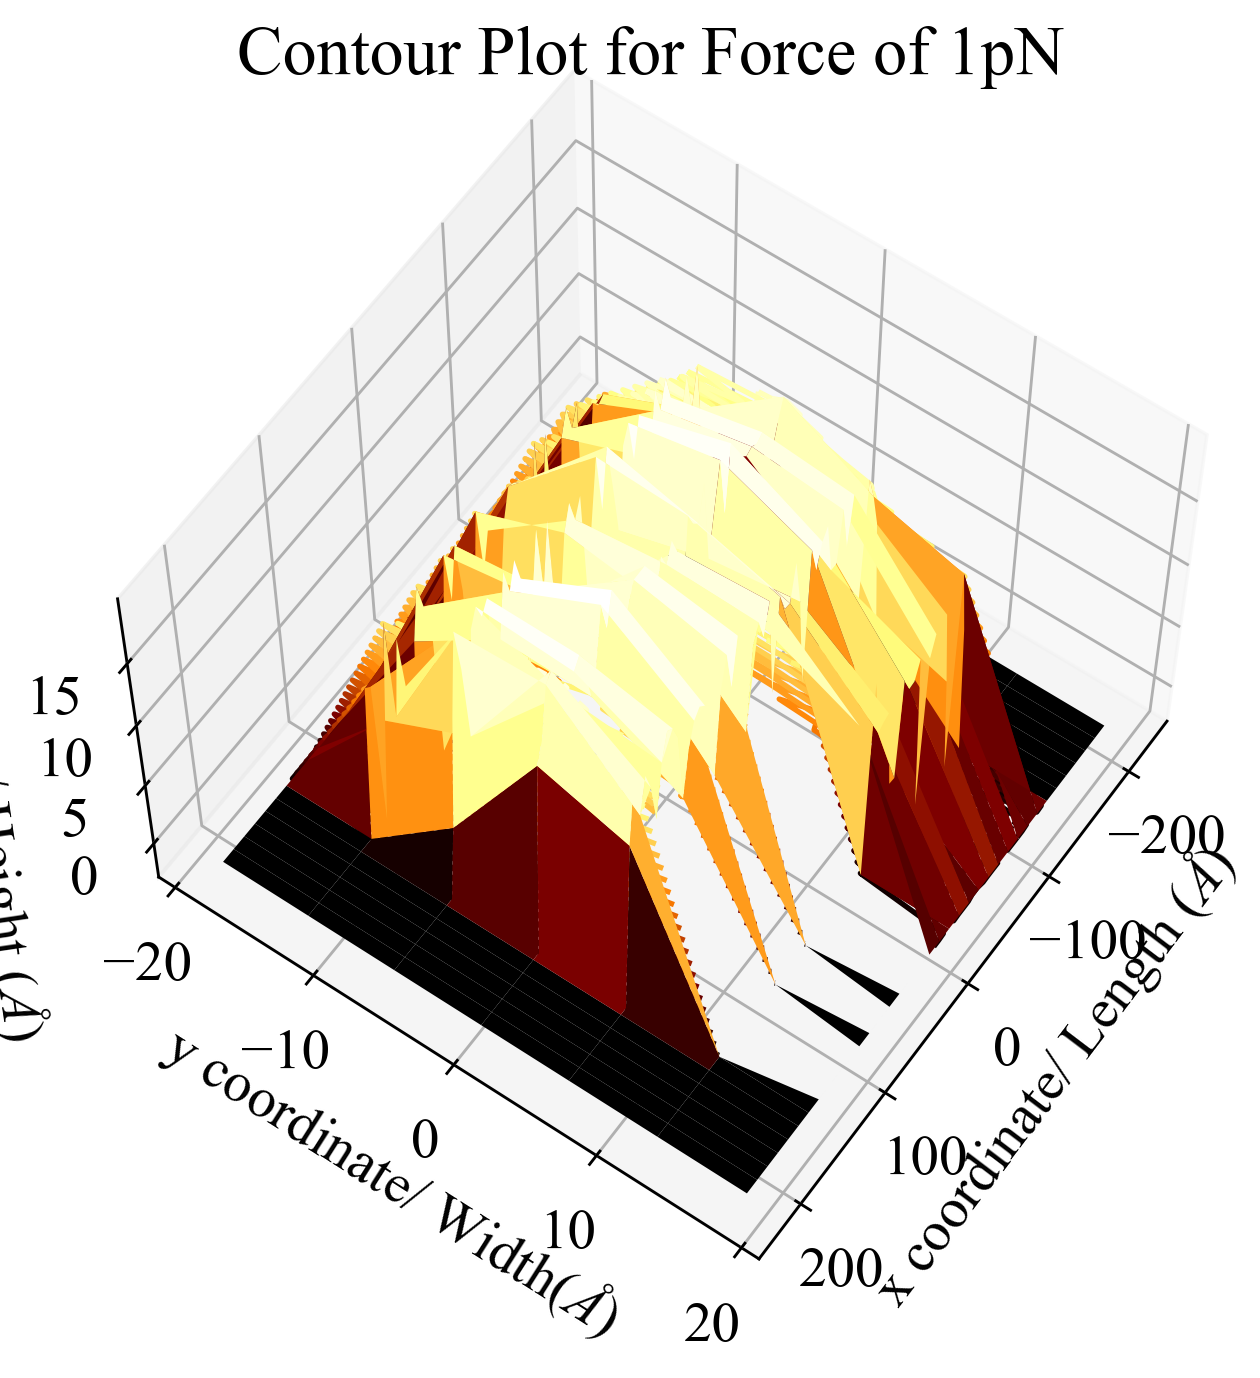

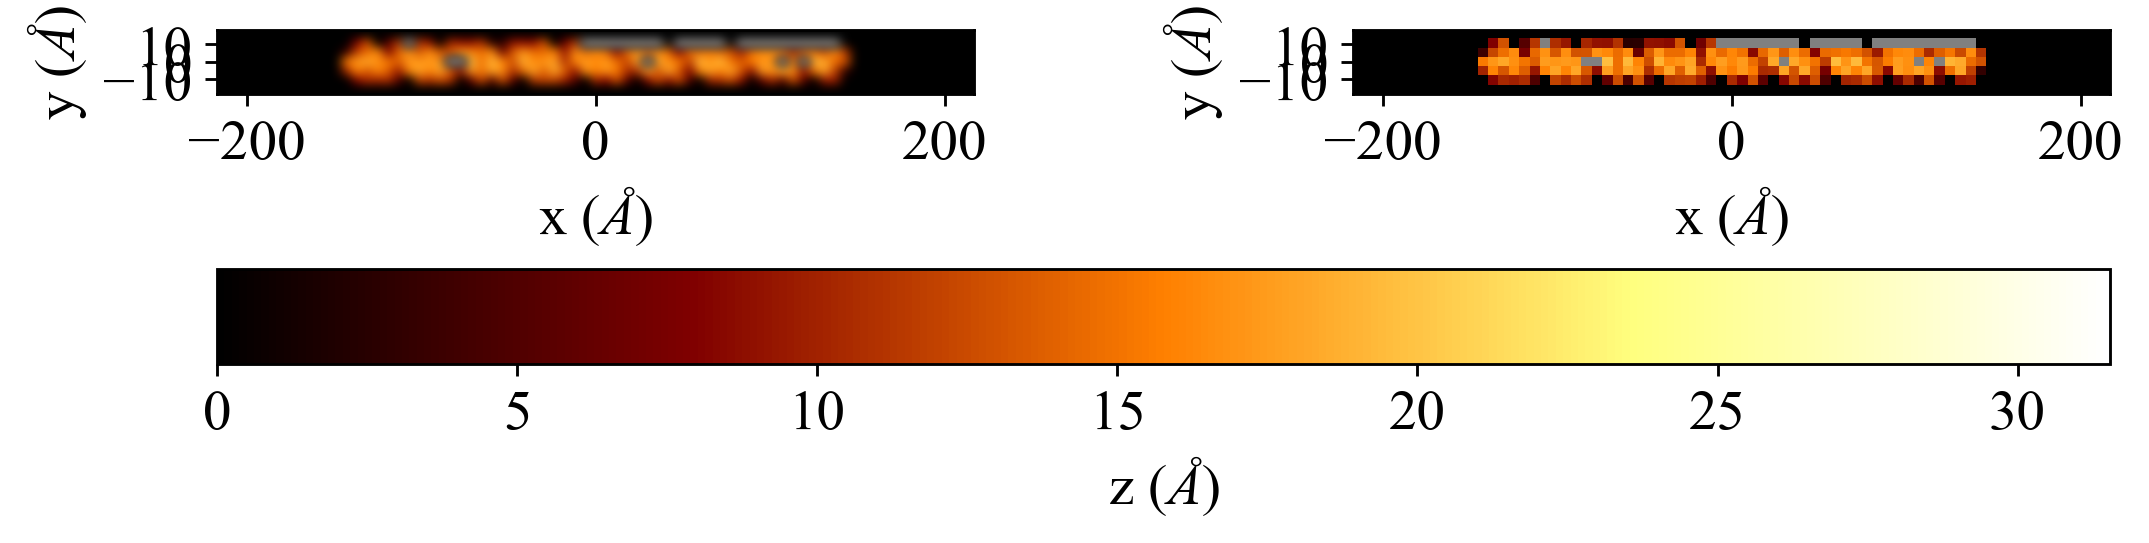

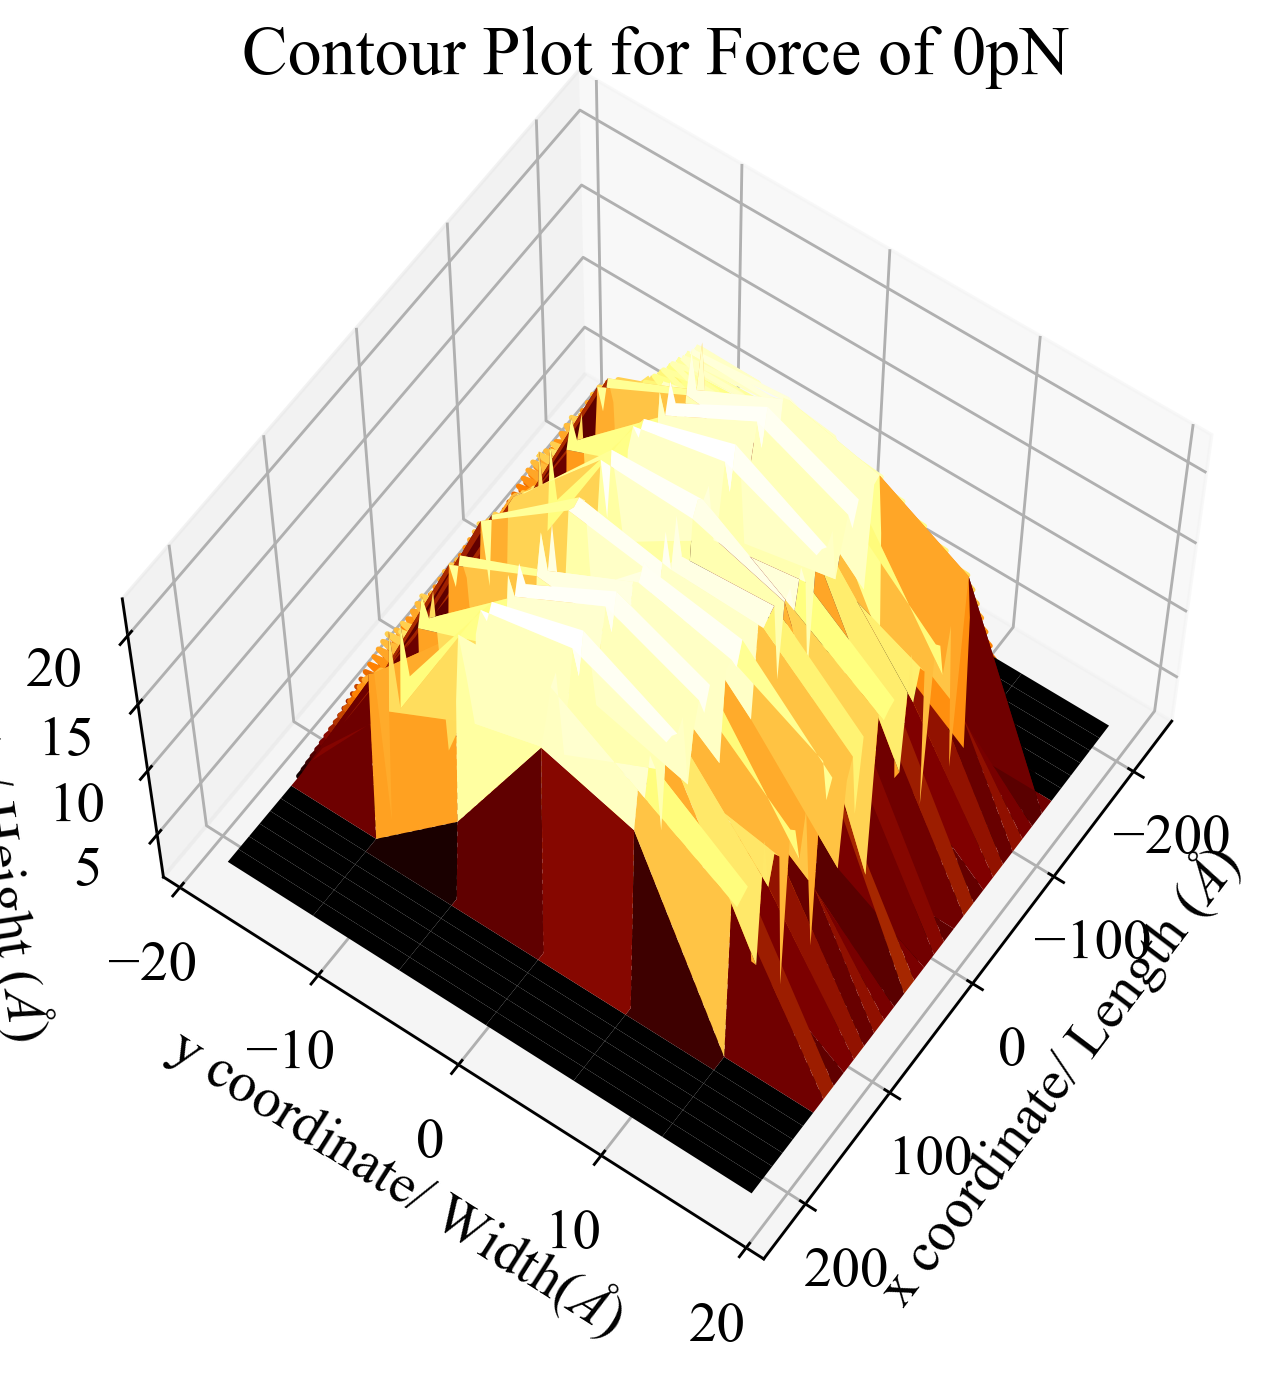

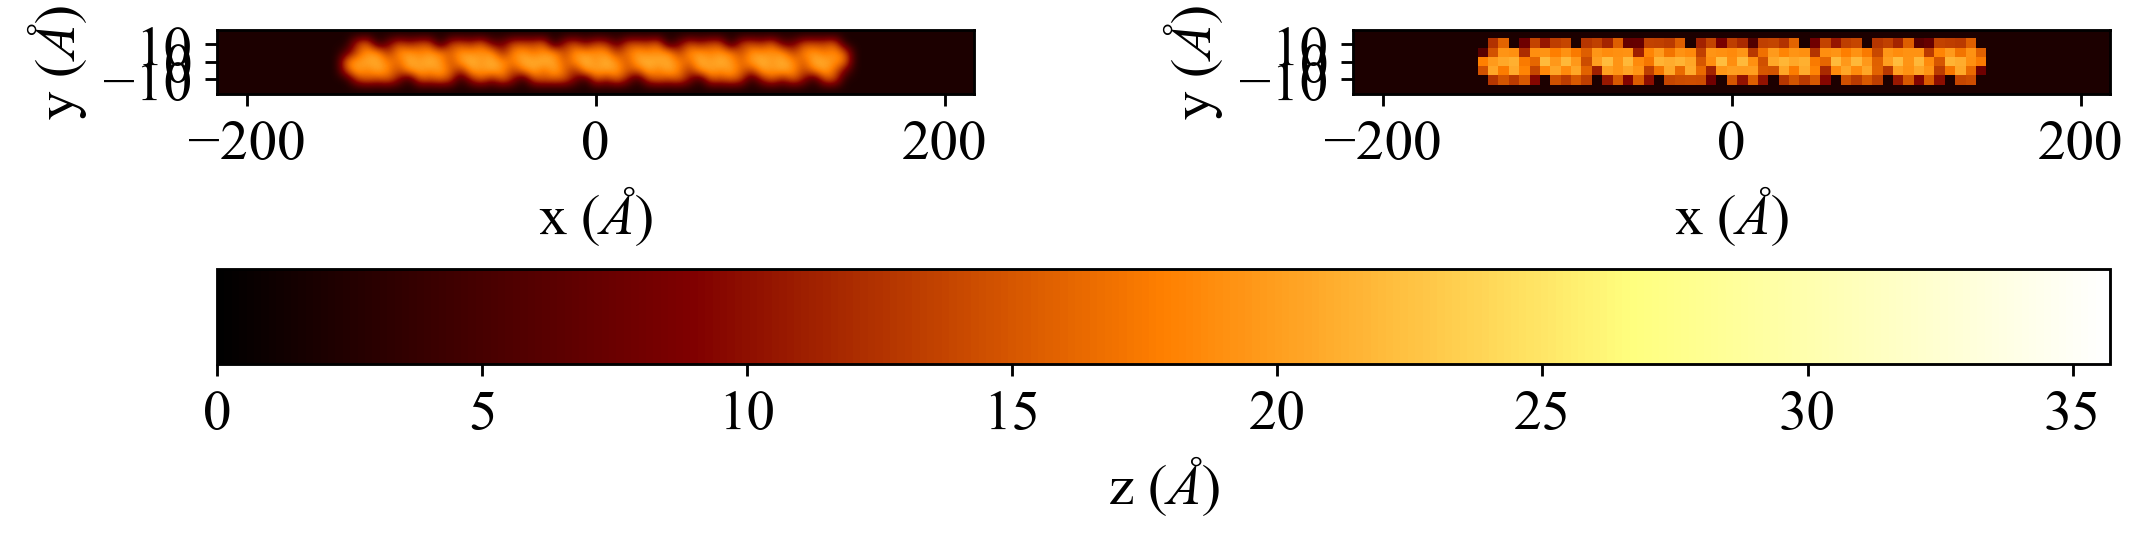

Simulation Complete - 0:05:05.409313


In [63]:
#  --------------------------------------------Remote Sever Variables-----------------------------------------------------
host = "kathleen.rc.ucl.ac.uk"
host = "myriad.rc.ucl.ac.uk"
port = 22
username = "zcapjgi"
password = "jos.Giblj003.315/Burnj003.315"

home     = '/home/zcapjgi'
scratch  = '/scratch/scratch/zcapjgi'

bashCommand = 'qsub'
abqCommand  = 'module load abaqus/2017 \n abaqus cae -noGUI'

# host = "128.40.163.27"
# port = 22
# username = "giblnbrnhm_j"
# password = "axenub13"
# home = '/home/giblnbrnhm_j@MECHENG2012'
# abqCommand  = '/opt/abaqus2018/abq2018 cae -noGUI'
# abqCommand  = '/opt/abaqus614/Commands/abq6141 cae -noGUI'


#  -----------------------------------------------Submission Variables-----------------------------------------------------
fileName = 'AFMRasterScan-Pos'
subData  = ['24:0:0', '4G', '80']
abqDir   = '/ABAQUS/AFM_Simulations/DNASimulation-0'

localPath  = os.getcwd()
remotePath = scratch + abqDir


#  -------------------------------------------Simulation Variables---------------------------------------------------------
# Surface variables                              #
pdb = 'bdna8'                                    # '1bna' 'bdna8' '4dqy' 'pyn1bna'
rotation = [0, 270, 60]                          # degrees
surfaceApprox = 0.2                              # arb
                                                 #
# Indentor variables                             #
indentorType = 'Capped'                          #
rIndentor = 2                                    # (x10^-10 m / Angstroms)
theta_degrees = 5                                # degrees
tip_length = 50                                  # (x10^-10 m / Angstroms)
                                                 #
# Scan variables                                 #
clearance = 0.5                                  # (x10^-10 m / Angstroms)
indentionDepth = clearance + 2                   # (x10^-10 m / Angstroms)
binSize  = 6                                     # (x10^-10 m / Angstroms)
forceRef = 1                                     # (x10^-10 N / pN)
contrast = 1.61                                  # arb
                                                 #
# ABAQUS variable                                #
timePeriod   = 1  #1.5                           # s
timeInterval = 0.1                               # s
meshSurface  = 2.5 # 0.6                         # (x10^-10 m / Angstroms)
meshBase     = 2                                 # (x10^-10 m / Angstroms)
meshIndentor = 0.6    #0.35                      # (x10^-10 m / Angstroms)


#  -------------------------------------------Simulation Script----------------------------------------------------------
AFMSimulation(host, port, username, password, remotePath, localPath, abqCommand, fileName, subData, 
            pdb, rotation, surfaceApprox, indentorType, rIndentor, theta_degrees, tip_length,
            indentionDepth, forceRef, contrast, binSize, clearance, meshSurface, meshBase, meshIndentor,  
            timePeriod, timeInterval,

            Preprocess    = False,
              
            Submission  = True,
            Transfer    = False, 
            Part        = False, 
            Input       = False, 
            Batch       = False, 
            Queue       = False, 
            Analysis    = True, 
            Retrieval   = True, 

            Postprocess = True, 
            ReturnData  = False,
              
            HSPlot        = True,
            MolecularView = False,
            DotPlot       = False,
            DataPlot      = False,                
              
            Noise        = [0,0,0.15], 
            ImagePadding = 1, 
            # SaveImages = localPath
            )

# Bash Commands

In [ ]:
# host = "kathleen.rc.ucl.ac.uk"
# # host = "myriad.rc.ucl.ac.uk"
# port = 22
# username = "zcapjgi"
# password = "ucl.Giblj003.315/Burnj003.315"

# home     = '/home/zcapjgi'
# scratch  = '/scratch/scratch/zcapjgi'

In [ ]:
# RemoteCommand(host, port, username, password, '', home, 'qstat')

In [ ]:
# for i in range(383, len(clipped_scanPos)):
#     jobName = 'AFMRasterScan-Pos'+str(int(i))
#     RemoteCommand(host, port, username, password, '', remotePath,'qsub -N '+ jobName +' batchScript.sh')

In [ ]:
# RemoteCommand(host, port, username, password, '',home,"qdel '*' ")

In [ ]:
# t0 = time.time()

# fileType = ['*.023', '*.cid', '*.dat', '*.lck', '*.mdl', '*.com','*.SMABulk', 
#             '*.msg', '*.prt', '*.sim', '*.sta', '*.stt', '*.tmp',  '*.SMAFocus']
# for file in fileType:
#     RemoteCommand(host, port, username, password, '',scratch, "find . -name "+ file +" -delete")

# t1 = time.time()
# print(t1-t0)

In [ ]:
# Remote_Terminal(host, port, username, password)